### Query to Hint based on LLMSteer Pipeline

## Setup

In [2]:
import torch


print("🖥️ Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "❌ CPU only")


🖥️ Device: NVIDIA RTX A6000


In [3]:
# import packages
import torch
import os.path
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skops.io import dump
from scipy.stats import gmean
from datetime import datetime
from collections import Counter

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from models.utils import prepare_data, load_data

🖥️ Device: NVIDIA RTX A6000
🚀 GPU detected — loading quantized model...


In [4]:
job_df = load_data()
job_df.head()

,filename,sql,hint_list,runtime_list,plan_tree,mean_runtime,sd_runtime
0,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,[23],"[2.533348560333252, 2.5383200645446777, 2.5536...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",2.550329,0.016500
1,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,"[35, 36]","[2.6349778175354004, 2.628606081008911, 2.6323...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",2.633306,0.003858
2,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,"[7, 8, 11, 12, 21, 22, 25, 26]","[1.3421952724456787, 1.328214406967163, 1.3486...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",1.338683,0.009532
3,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,[9],"[3.4522547721862793, 3.441565752029419, 3.3839...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",3.449659,0.037371
4,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,[37],"[4.567062854766846, 4.8856282234191895, 4.5464...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",4.619872,0.133072


## Exploratory Data Analysis

#### Distribution of Runtime Metrics

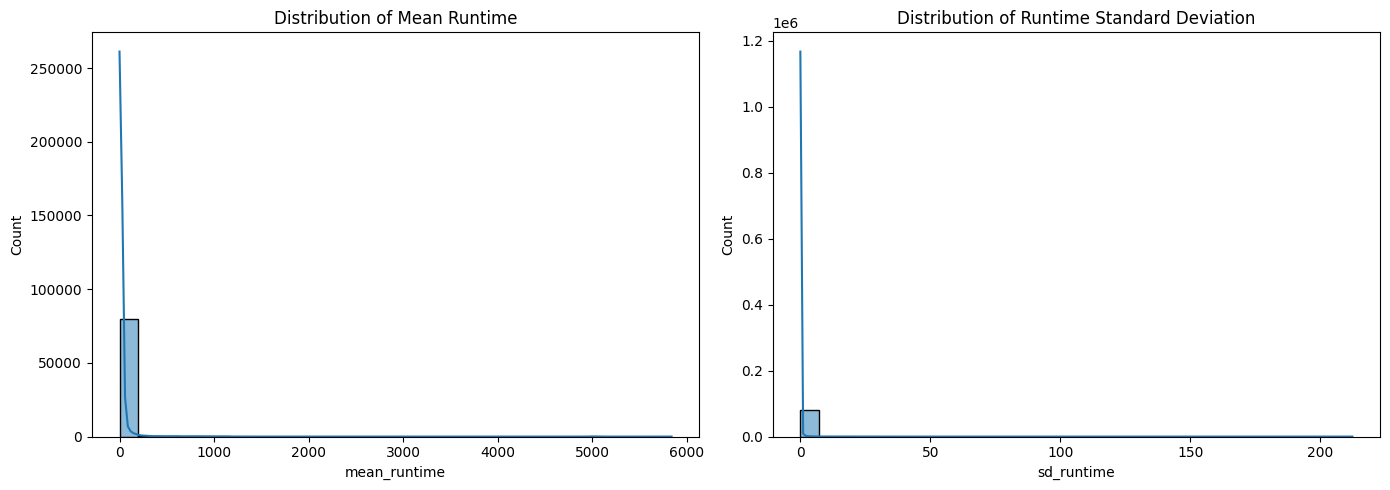

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(job_df['mean_runtime'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Mean Runtime')
sns.histplot(job_df['sd_runtime'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Runtime Standard Deviation')
plt.tight_layout()
plt.show()


#### Runtime Stability vs Efficiency

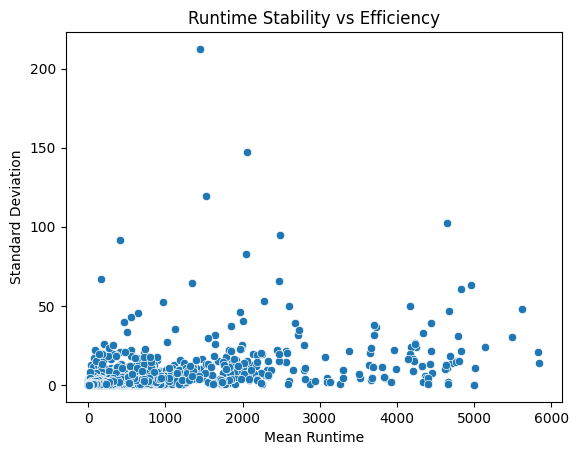

In [6]:
sns.scatterplot(data=job_df, x='mean_runtime', y='sd_runtime')
plt.title("Runtime Stability vs Efficiency")
plt.xlabel("Mean Runtime")
plt.ylabel("Standard Deviation")
plt.show()


#### Hint Set Cardinality vs Runtime

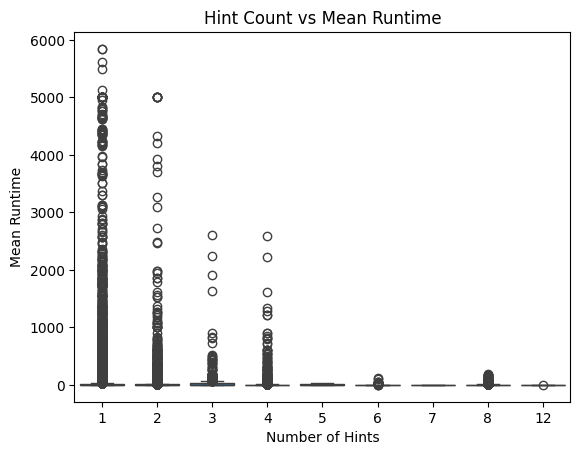

In [7]:
job_df['hint_count'] = job_df['hint_list'].apply(len)

sns.boxplot(x='hint_count', y='mean_runtime', data=job_df)
plt.title("Hint Count vs Mean Runtime")
plt.xlabel("Number of Hints")
plt.ylabel("Mean Runtime")
plt.show()


### Hints & Latency

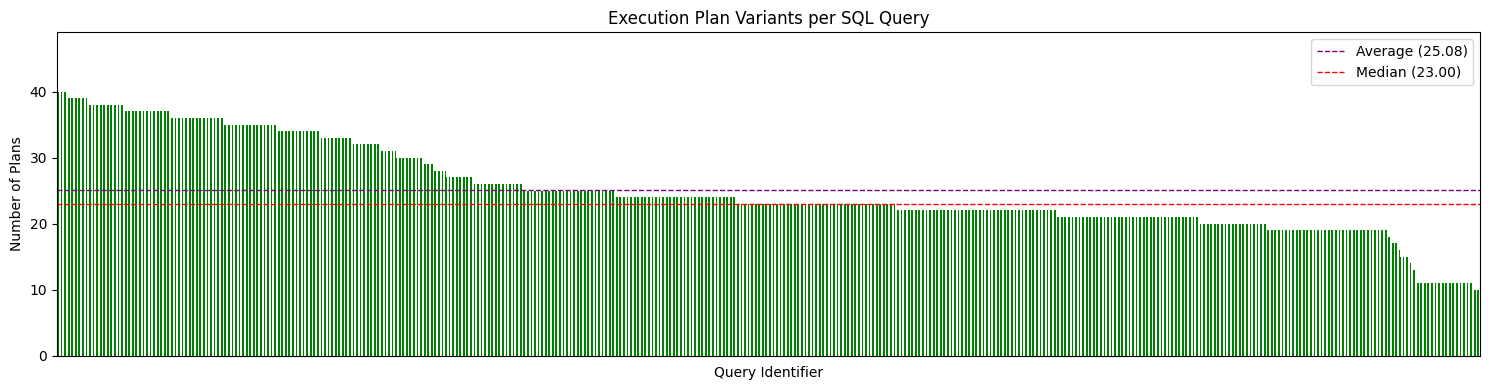

In [ ]:
import matplotlib.pyplot as plt

# Compute how many plans exist per unique SQL query
plan_summary = job_df.groupby('filename')['plan_tree'].count().sort_values(ascending=False)

# Initialize plot
fig, axis = plt.subplots(figsize=(15, 4))

# Bar plot with custom color
plan_summary.plot(kind='bar', ax=axis, color='green')  

# Compute average and median number of plans
avg_plans = plan_summary.mean()
med_plans = plan_summary.median()

# Draw horizontal lines for average and median
axis.axhline(avg_plans, color='purple', linestyle='--', linewidth=1)
axis.axhline(med_plans, color='red', linestyle='--', linewidth=1)

# Axis labels and title
axis.set_title('Execution Plan Variants per SQL Query')
axis.set_xlabel('Query Identifier')
axis.set_ylabel('Number of Plans')

# Simplify x-axis to reduce clutter
axis.set_xticks([])

# Optional: adjust y-limit to total unique hint count
max_hints = job_df.explode('hint_list')['hint_list'].nunique()
axis.set_ylim([0, max_hints])

# Legend for mean and median lines
axis.legend([
    f"Average ({avg_plans:.2f})",
    f"Median ({med_plans:.2f})"
])

plt.tight_layout()
plt.show()



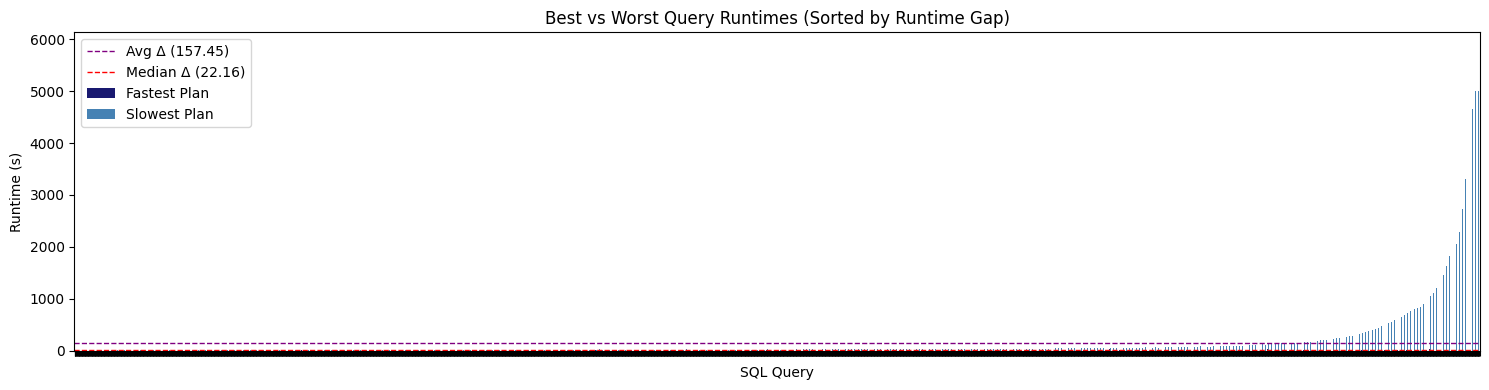

In [14]:
import matplotlib.pyplot as plt

# Aggregate min and max mean runtimes per query
runtime_stats = (
    job_df.groupby('filename', as_index=False)
    .agg(min_runtime=('mean_runtime', 'min'), max_runtime=('mean_runtime', 'max'))
)

# Sort by performance gap (delta)
runtime_stats['runtime_gap'] = runtime_stats['max_runtime'] - runtime_stats['min_runtime']
runtime_stats = runtime_stats.sort_values(by='runtime_gap')

# Plot setup
fig, ax = plt.subplots(figsize=(15, 4))

# Bar plot with dark blue tones
runtime_stats.plot(
    x='filename',
    y=['min_runtime', 'max_runtime'],
    kind='bar',
    ax=ax,
    color=['midnightblue', 'steelblue'],  # Darker blues
    title='Best vs Worst Query Runtimes (Sorted by Runtime Gap)',
    xlabel='SQL Query',
    ylabel='Runtime (s)'
)

# Draw average and median runtime delta lines
avg_gap = runtime_stats['runtime_gap'].mean()
med_gap = runtime_stats['runtime_gap'].median()
ax.axhline(avg_gap, color='purple', linestyle='--', linewidth=1)
ax.axhline(med_gap, color='red', linestyle='--', linewidth=1)

# Final plot tweaks
ax.set_xticklabels([])
ax.legend([
    f"Avg Δ ({avg_gap:.2f})", 
    f"Median Δ ({med_gap:.2f})", 
    'Fastest Plan', 
    'Slowest Plan'
])
plt.xticks(fontsize=3)
plt.tight_layout()
plt.show()


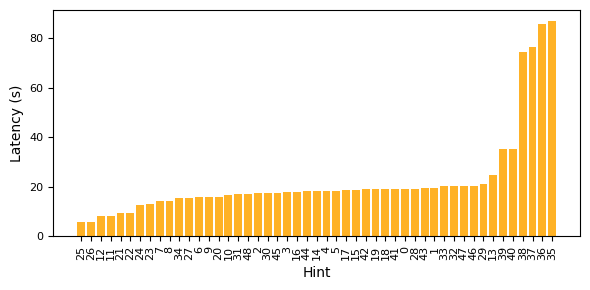

In [21]:

# Suppress any matplotlib warnings
warnings.filterwarnings('ignore')

# Prepare the data: flatten hint lists and associate each with its mean runtime
expanded_data = job_df.explode('hint_list')[['hint_list', 'mean_runtime']]

# Calculate the 90th percentile latency for each hint
latency_90th = (
    expanded_data.groupby('hint_list')['mean_runtime']
    .quantile(0.9)
    .reset_index()
    .sort_values(by='mean_runtime')
)

# Plotting
fig, ax = plt.subplots(figsize=(6, 3))

bars = ax.bar(
    latency_90th['hint_list'].astype(str),
    latency_90th['mean_runtime'],
    color='orange',
    alpha=0.85
)

# Customize axes and labels
ax.set_title('')
ax.set_ylabel('Latency (s)')
ax.set_xlabel('Hint')
ax.tick_params(axis='x', labelrotation=90, labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Final layout
plt.tight_layout()
plt.show()


### Embeddings Generation

In [22]:
X, hint_l, opt_l, targets_l = prepare_data(job_df, './embeddings', f'syntaxA_embedding', False)
scaler = StandardScaler()
X_viz = torch.Tensor(scaler.fit_transform(X))



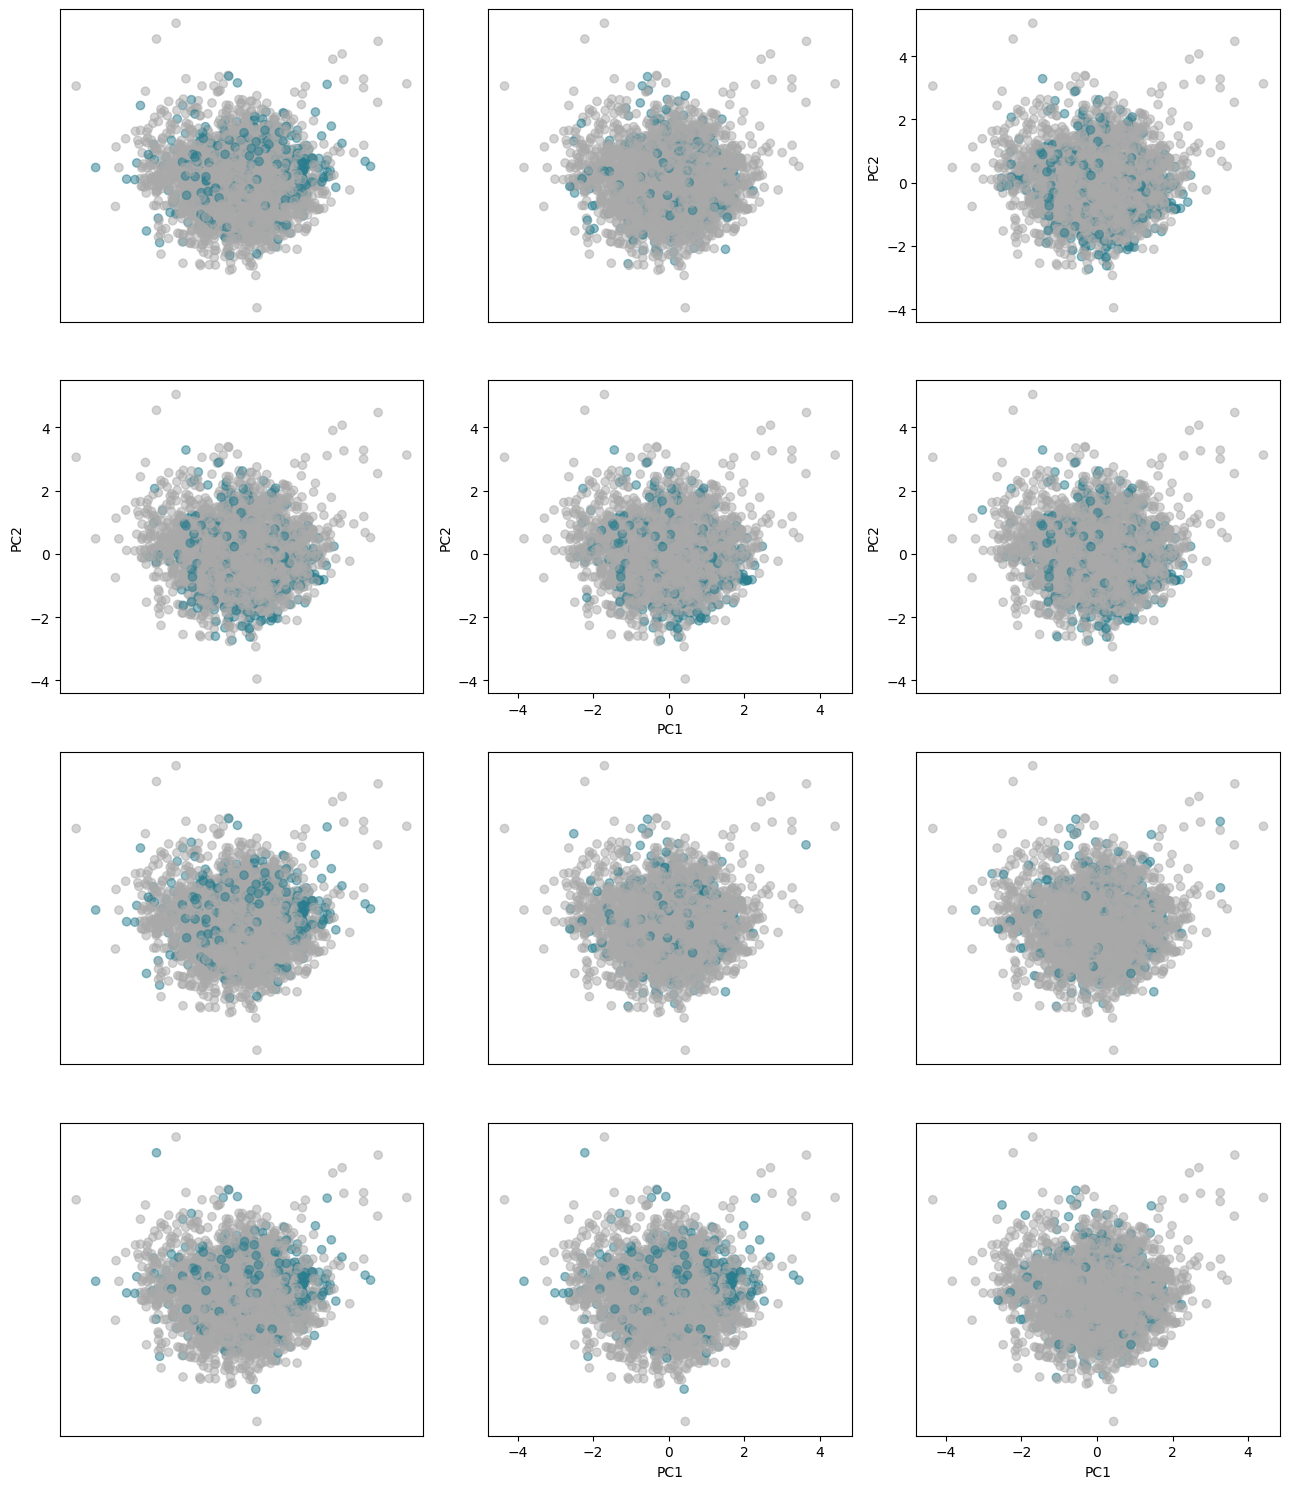

In [24]:

# Number of top hints to visualize
num_hints = 12
grid_shape = (4, 3)
inactive_color = 'darkgrey'
highlight_color = '#287D8EFF'

# Get top-k most frequent optimal hint indices
most_common_hints = (
    pd.Series(torch.where(hint_l == opt_l)[1])
    .value_counts()
    .head(num_hints)
    .index.to_numpy()
    .reshape(grid_shape)
)

# Setup subplot grid
fig, axes = plt.subplots(*grid_shape, figsize=(13, 15))

# Flatten axes for easier iteration
flat_axes = axes.flatten()

# Rearranged hint layout for better visual distribution
display_order = [4, 5, 0, 1, 2, 3, 6, 7, 8, 9, 10, 11]

for pos, ax_idx in enumerate(display_order):
    ax = flat_axes[pos]
    hint_idx = most_common_hints.flatten()[ax_idx]

    # Default color for all points is highlight; grey out mismatches
    color_map = np.array([highlight_color] * X_viz.size(0))
    mask = (hint_l[:, hint_idx] != opt_l[:, hint_idx])
    color_map[mask] = inactive_color

    # Scatter plot
    ax.scatter(X_viz[:, 0], X_viz[:, 1], alpha=0.5, c=color_map)

    # Axis visibility
    if hint_idx in {48, 6, 34, 20}:
        ax.set_ylabel("PC2")
    else:
        ax.get_yaxis().set_visible(False)

    if hint_idx in {0, 20, 30}:
        ax.set_xlabel("PC1")
    else:
        ax.get_xaxis().set_visible(False)

    # Hint label
    ax.annotate(
        f"Hint {hint_idx}", 
        (-27.5, -42.5), 
        bbox=dict(boxstyle="round", fc="0.8")
    )

plt.tight_layout()
plt.show()


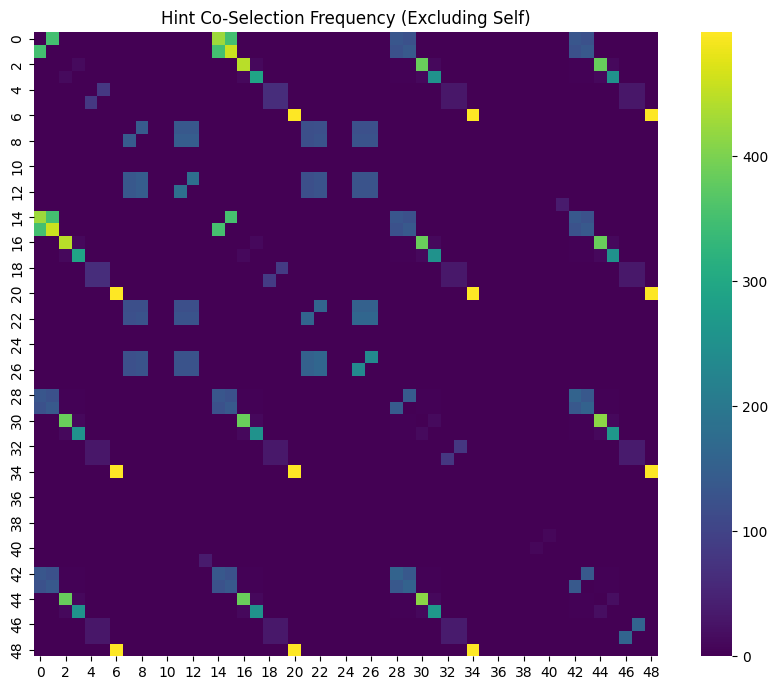

In [25]:

# Convert match matrix (hint == optimal) to binary
match_matrix = (hint_l == opt_l).int()

# Compute co-occurrence by matrix multiplication
co_occurrence = match_matrix.T @ match_matrix

# Set diagonal to zero (to ignore self-match)
co_occurrence.fill_diagonal_(0)

# Plotting
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    co_occurrence,
    cmap='viridis',
    ax=ax,
    square=True
)

# Title and layout
ax.set_title('Hint Co-Selection Frequency (Excluding Self)')
plt.tight_layout()
plt.show()


### Query2Hint Model training on LLMSteer Pipleline

In [ ]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
RANDOM_SEED = 24508
THRESHOLD = 0.5

original_sql, hint_l, opt_l, targets_l, spaced_sql, tabbed_sql = prepare_data(job_df, './embeddings', f'syntaxA_embedding', True, augment=True)
p = 0.8
k = 10

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
scaler = StandardScaler()

model_cfgs = [
    { 'name': 'LRG-5-False', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 5 , 'scale': False},
    { 'name': 'SVC_RBF-5-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 5 , 'scale': False},
    { 'name': 'SVC_LIN-5-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 5 , 'scale': False},
    { 'name': 'GBC-5-False', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100, learning_rate=0.1), 'pcs': 5 , 'scale': False},
    { 'name': 'RFC-5-False', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 5 , 'scale': False},
    { 'name': 'LRG-50-False', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 50 , 'scale': False},
    { 'name': 'SVC_RBF-50-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 50 , 'scale': False},
    { 'name': 'SVC_LIN-50-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 50 , 'scale': False},
    { 'name': 'GBC-50-False', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100, learning_rate=0.1), 'pcs': 50 , 'scale': False},
    { 'name': 'RFC-50-False', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 50 , 'scale': False},
    { 'name': 'LRG-120-False', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 120 , 'scale': False},
    { 'name': 'SVC_RBF-120-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 120 , 'scale': False},
    { 'name': 'SVC_LIN-120-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 120 , 'scale': False},
    { 'name': 'GBC-120-False', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100, learning_rate=0.1), 'pcs': 120 , 'scale': False},
    { 'name': 'RFC-120-False', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 120 , 'scale': False},
    { 'name': 'LRG-5-True', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 5, 'scale': True},
    { 'name': 'SVC_RBF-5-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 5, 'scale': True},
    { 'name': 'SVC_LIN-5-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 5, 'scale': True},
    { 'name': 'GBC-5-True', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100, learning_rate=0.1), 'pcs': 5, 'scale': True},
    { 'name': 'RFC-5-True', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 5, 'scale': True},
    { 'name': 'LRG-50-True', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 50, 'scale': True},
    { 'name': 'SVC_RBF-50-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 50, 'scale': True},
    { 'name': 'SVC_LIN-50-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 50, 'scale': True},
    { 'name': 'GBC-50-True', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100, learning_rate=0.1), 'pcs': 50, 'scale': True},
    { 'name': 'RFC-50-True', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 50, 'scale': True},
    { 'name': 'LRG-120-True', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 120, 'scale': True},
    { 'name': 'SVC_RBF-120-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 120, 'scale': True},
    { 'name': 'SVC_LIN-120-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 120, 'scale': True},
    { 'name': 'GBC-120-True', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100, learning_rate=0.1), 'pcs': 120, 'scale': True},
    { 'name': 'RFC-120-True', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 120, 'scale': True},
#     { 'name': f'XGB', 'estimator': XGBClassifier(random_state=RANDOM_SEED, n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss'), 'pcs': 120, 'scale': True },
#     { 'name': f'LGBM', 'estimator': LGBMClassifier(random_state=RANDOM_SEED, n_estimators=100, learning_rate=0.1), 'pcs': 120, 'scale': True },
#     { 'name': f'CAT', 'estimator': CatBoostClassifier(random_state=RANDOM_SEED, iterations=100, learning_rate=0.1, verbose=0), 'pcs': 120, 'scale': True },
#     { 'name': f'MLP', 'estimator': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=RANDOM_SEED), 'pcs': 120, 'scale': True },
]
for cfg in model_cfgs:
    # classification metrics
    cfg['model_train_accuracy'] = list()
    cfg['model_test_accuracy'] = list()
    cfg['model_train_recall'] = list()
    cfg['model_test_recall'] = list()
    cfg['model_train_precision'] = list()
    cfg['model_test_precision'] = list()
    cfg['model_train_f1score'] = list()
    cfg['model_test_f1score'] = list()
    cfg['model_train_auroc'] = list()
    cfg['model_test_auroc'] = list()
    
    cfg['apriori_train_distribution'] = list()
    cfg['apriori_test_distribution'] = list()

    # hint steering strategy performance
    cfg['train_model_workload'] = list()
    cfg['train_opt_workload'] = list()
    cfg['train_benchmark_workload'] = list()
    cfg['train_apriori_workload'] = list()
    cfg['test_model_workload'] = list()
    cfg['test_opt_workload'] = list()
    cfg['test_benchmark_workload'] = list()
    cfg['test_apriori_workload'] = list()

    cfg['train_model_p90'] = list()
    cfg['train_opt_p90'] = list()
    cfg['train_benchmark_p90'] = list()
    cfg['train_apriori_p90'] = list()
    cfg['test_model_p90'] = list()
    cfg['test_opt_p90'] = list()
    cfg['test_benchmark_p90'] = list()
    cfg['test_apriori_p90'] = list()

    cfg['train_model_median'] = list()
    cfg['train_opt_median'] = list()
    cfg['train_benchmark_median'] = list()
    cfg['train_apriori_median'] = list()
    cfg['test_model_median'] = list()
    cfg['test_opt_median'] = list()
    cfg['test_benchmark_median'] = list()
    cfg['test_apriori_median'] = list()

    # robustness
    cfg['model_spaced_accuracy'] = list()
    cfg['model_spaced_recall'] = list()
    cfg['model_spaced_precision'] = list()
    cfg['model_spaced_f1score'] = list()
    cfg['model_spaced_auroc'] = list()
    cfg['model_spaced_workload'] = list()
    cfg['model_spaced_p90'] = list()
    cfg['model_spaced_median'] = list()

    cfg['model_tabbed_accuracy'] = list()
    cfg['model_tabbed_recall'] = list()
    cfg['model_tabbed_precision'] = list()
    cfg['model_tabbed_f1score'] = list()
    cfg['model_tabbed_auroc'] = list()
    cfg['model_tabbed_workload'] = list()
    cfg['model_tabbed_p90'] = list()
    cfg['model_tabbed_median'] = list()


for i, (train_idx, test_idx) in enumerate(StratifiedShuffleSplit(n_splits=k, train_size=p, random_state=RANDOM_SEED).split(original_sql, targets_l)):
    print(f'[{datetime.now().isoformat()}] Beginning experiments in CV fold {i+1}')
    X_train, X_test, y_train, y_test = original_sql[train_idx].numpy(), original_sql[test_idx].numpy(), targets_l[train_idx].numpy(), targets_l[test_idx].numpy()
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    X_spaced_test = pipeline.transform(spaced_sql[test_idx].numpy())
    X_tabbed_test = pipeline.transform(tabbed_sql[test_idx].numpy())

    weights = {
        0: ((targets_l[train_idx].type(torch.long) == 1).sum() / (targets_l[train_idx].type(torch.long) == 0).sum()).item(), 
        1: ((targets_l[train_idx].type(torch.long) == 0).sum() / (targets_l[train_idx].type(torch.long) == 1).sum()).item() 
    }

    benchmark_const = torch.LongTensor([0])
    longtail_const = torch.LongTensor([26])

    apriori_train_distribution = (y_train.shape[0] - y_train.sum())/y_train.shape[0]
    apriori_test_distribution = (y_test.shape[0] - y_test.sum())/y_test.shape[0]
    apriori_train_runtimes = hint_l[train_idx].gather(1, torch.where(torch.Tensor(y_train) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
    apriori_test_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_test) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))

    train_opt_workload = opt_l[train_idx].mean(dim=1).sum()
    train_benchmark_workload = hint_l[train_idx,0].sum()
    train_apriori_workload = apriori_train_runtimes.sum()
    test_opt_workload = opt_l[test_idx].mean(dim=1).sum()
    test_benchmark_workload = hint_l[test_idx,0].sum()
    test_apriori_workload = apriori_test_runtimes.sum()

    train_opt_p90 = opt_l[train_idx].mean(dim=1).quantile(0.90)
    train_benchmark_p90 = hint_l[train_idx,0].quantile(0.90)
    train_apriori_p90 = apriori_train_runtimes.quantile(0.90)
    test_opt_p90 = opt_l[test_idx].mean(dim=1).quantile(0.90)
    test_benchmark_p90 = hint_l[test_idx,0].quantile(0.90)
    test_apriori_p90 = apriori_test_runtimes.quantile(0.90)

    train_opt_median = opt_l[train_idx].mean(dim=1).median()
    train_benchmark_median = hint_l[train_idx,0].median()
    train_apriori_median = apriori_train_runtimes.median()
    test_opt_median = opt_l[test_idx].mean(dim=1).median()
    test_benchmark_median = hint_l[test_idx,0].median()
    test_apriori_median = apriori_test_runtimes.median()

    for cfg in model_cfgs:
        print(f'[{datetime.now().isoformat()}] Beginning to Train {cfg["name"]} Model')
        PCS = cfg['pcs']

        if cfg['scale']:
            X_train_f = scaler.fit_transform(X_train)
            X_test_f = scaler.transform(X_test)
            X_spaced_test_f = scaler.transform(X_spaced_test)
            X_tabbed_test_f = scaler.transform(X_tabbed_test)
        else:
            X_train_f = X_train.copy()
            X_test_f = X_test.copy()
            X_spaced_test_f = X_spaced_test.copy()
            X_tabbed_test_f = X_tabbed_test.copy()


        if hasattr(cfg['estimator'], 'class_weight'):
            cfg['estimator'].class_weight = weights.copy()

        cfg['estimator'].fit(X_train_f[:,:cfg['pcs']], y_train)
        y_train_pred = cfg['estimator'].predict(X_train_f[:,:PCS])
        y_test_pred = cfg['estimator'].predict(X_test_f[:,:PCS])
        
        y_spaced_pred = cfg['estimator'].predict(X_spaced_test_f[:,:PCS])
        y_tabbed_pred = cfg['estimator'].predict(X_tabbed_test_f[:,:PCS])

        # classification performance
        cfg['model_train_accuracy'].append(accuracy_score(y_train, y_train_pred))
        cfg['model_test_accuracy'].append(accuracy_score(y_test, y_test_pred))
        cfg['model_train_recall'].append(recall_score(y_train, y_train_pred))
        cfg['model_test_recall'].append(recall_score(y_test, y_test_pred))
        cfg['model_train_precision'].append(precision_score(y_train, y_train_pred))
        cfg['model_test_precision'].append(precision_score(y_test, y_test_pred))
        cfg['model_train_f1score'].append(f1_score(y_train, y_train_pred))
        cfg['model_test_f1score'].append(f1_score(y_test, y_test_pred))
        if hasattr(cfg['estimator'], 'predict_proba'):
            cfg['model_train_auroc'].append(roc_auc_score(y_train, cfg['estimator'].predict_proba(X_train_f[:,:PCS])[:,1]))
            cfg['model_test_auroc'].append(roc_auc_score(y_test, cfg['estimator'].predict_proba(X_test_f[:,:PCS])[:,1]))
            cfg['model_spaced_auroc'].append(roc_auc_score(y_test, cfg['estimator'].predict_proba(X_spaced_test_f[:,:PCS])[:,1]))
            cfg['model_tabbed_auroc'].append(roc_auc_score(y_test, cfg['estimator'].predict_proba(X_tabbed_test_f[:,:PCS])[:,1]))
        else:
            cfg['model_train_auroc'].append(roc_auc_score(y_train, cfg['estimator'].decision_function(X_train_f[:,:PCS])))
            cfg['model_test_auroc'].append(roc_auc_score(y_test, cfg['estimator'].decision_function(X_test_f[:,:PCS])))
            cfg['model_spaced_auroc'].append(roc_auc_score(y_test, cfg['estimator'].decision_function(X_spaced_test_f[:,:PCS])))
            cfg['model_tabbed_auroc'].append(roc_auc_score(y_test, cfg['estimator'].decision_function(X_tabbed_test_f[:,:PCS])))

        cfg['apriori_train_distribution'].append(apriori_train_distribution)
        cfg['apriori_test_distribution'].append(apriori_test_distribution)

        # hint steering strategy performance
        model_train_runtimes = hint_l[train_idx].gather(1, torch.where(torch.Tensor(y_train_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
        model_test_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_test_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))

        train_model_workload = model_train_runtimes.sum()
        test_model_workload = model_test_runtimes.sum()
        train_model_p90 = model_train_runtimes.quantile(0.90)
        test_model_p90 = model_test_runtimes.quantile(0.90)
        train_model_median = model_train_runtimes.median()
        test_model_median = model_test_runtimes.median()

        cfg['train_opt_workload'].append(train_opt_workload.item())
        cfg['train_benchmark_workload'].append(train_benchmark_workload.item())
        cfg['train_model_workload'].append(train_model_workload.item())
        cfg['train_apriori_workload'].append(train_apriori_workload.item())
        cfg['test_opt_workload'].append(test_opt_workload.item())
        cfg['test_benchmark_workload'].append(test_benchmark_workload.item())
        cfg['test_model_workload'].append(test_model_workload.item())
        cfg['test_apriori_workload'].append(test_apriori_workload.item())

        cfg['train_opt_p90'].append(train_opt_p90.item())
        cfg['train_benchmark_p90'].append(train_benchmark_p90.item())
        cfg['train_model_p90'].append(train_model_p90.item())
        cfg['train_apriori_p90'].append(train_apriori_p90.item())
        cfg['test_opt_p90'].append(test_opt_p90.item())
        cfg['test_benchmark_p90'].append(test_benchmark_p90.item())
        cfg['test_model_p90'].append(test_model_p90.item())
        cfg['test_apriori_p90'].append(test_apriori_p90.item())

        cfg['train_opt_median'].append(train_opt_median.item())
        cfg['train_benchmark_median'].append(train_benchmark_median.item())
        cfg['train_model_median'].append(train_model_median.item())
        cfg['train_apriori_median'].append(train_apriori_median.item())
        cfg['test_opt_median'].append(test_opt_median.item())
        cfg['test_benchmark_median'].append(test_benchmark_median.item())
        cfg['test_model_median'].append(test_model_median.item())
        cfg['test_apriori_median'].append(test_apriori_median.item()) 

        # robustness
        model_spaced_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_spaced_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
        model_spaced_workload = model_spaced_runtimes.sum()
        model_spaced_p90 = model_spaced_runtimes.quantile(0.90)
        model_spaced_median = model_spaced_runtimes.median()
        cfg['model_spaced_accuracy'].append(accuracy_score(y_test, y_spaced_pred))
        cfg['model_spaced_recall'].append(recall_score(y_test, y_spaced_pred))
        cfg['model_spaced_precision'].append(precision_score(y_test, y_spaced_pred))
        cfg['model_spaced_f1score'].append(f1_score(y_test, y_spaced_pred))
        cfg['model_spaced_workload'].append(model_spaced_workload.item())
        cfg['model_spaced_p90'].append(model_spaced_p90.item())
        cfg['model_spaced_median'].append(model_spaced_median.item())

        model_tabbed_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_tabbed_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
        model_tabbed_workload = model_tabbed_runtimes.sum()
        model_tabbed_p90 = model_tabbed_runtimes.quantile(0.90)
        model_tabbed_median = model_tabbed_runtimes.median()
        cfg['model_tabbed_accuracy'].append(accuracy_score(y_test, y_tabbed_pred))
        cfg['model_tabbed_recall'].append(recall_score(y_test, y_tabbed_pred))
        cfg['model_tabbed_precision'].append(precision_score(y_test, y_tabbed_pred))
        cfg['model_tabbed_f1score'].append(f1_score(y_test, y_tabbed_pred))
        cfg['model_tabbed_workload'].append(model_tabbed_workload.item())
        cfg['model_tabbed_p90'].append(model_tabbed_p90.item())
        cfg['model_tabbed_median'].append(model_tabbed_median.item())

    print()

[2025-06-04T10:48:05.210656] Beginning experiments in CV fold 1
[2025-06-04T10:48:05.636936] Beginning to Train LRG-5-False Model
[2025-06-04T10:48:05.734840] Beginning to Train SVC_RBF-5-False Model
[2025-06-04T10:48:06.639383] Beginning to Train SVC_LIN-5-False Model
[2025-06-04T10:48:12.771924] Beginning to Train GBC-5-False Model
[2025-06-04T10:48:13.395806] Beginning to Train RFC-5-False Model
[2025-06-04T10:48:14.217801] Beginning to Train LRG-50-False Model
[2025-06-04T10:48:14.310494] Beginning to Train SVC_RBF-50-False Model
[2025-06-04T10:48:15.683560] Beginning to Train SVC_LIN-50-False Model
[2025-06-04T10:48:19.792235] Beginning to Train GBC-50-False Model
[2025-06-04T10:48:24.370560] Beginning to Train RFC-50-False Model
[2025-06-04T10:48:26.367053] Beginning to Train LRG-120-False Model
[2025-06-04T10:48:26.477299] Beginning to Train SVC_RBF-120-False Model
[2025-06-04T10:48:28.732897] Beginning to Train SVC_LIN-120-False Model
[2025-06-04T10:48:35.622454] Beginning to T

In [27]:
model_performances = pd.DataFrame(model_cfgs)
model_performances = model_performances.drop(columns=['pcs'])

# --------------- classification metrics --------------- #
model_performances['model_train_accuracy_mean'] = model_performances.model_train_accuracy.apply(lambda x: np.array(x).mean())
model_performances['model_train_accuracy_std'] = model_performances.model_train_accuracy.apply(lambda x: np.array(x).std())
model_performances['model_test_accuracy_mean'] = model_performances.model_test_accuracy.apply(lambda x: np.array(x).mean())
model_performances['model_test_accuracy_std'] = model_performances.model_test_accuracy.apply(lambda x: np.array(x).std())
model_performances['apriori_train_distribution_mean'] = model_performances.apriori_train_distribution.apply(lambda x: np.array(x).mean())
model_performances['apriori_train_distribution_std'] = model_performances.apriori_train_distribution.apply(lambda x: np.array(x).std())
model_performances['apriori_test_distribution_mean'] = model_performances.apriori_test_distribution.apply(lambda x: np.array(x).mean())
model_performances['apriori_test_distribution_std'] = model_performances.apriori_test_distribution.apply(lambda x: np.array(x).std())

model_performances['model_train_recall_mean'] = model_performances.model_train_recall.apply(lambda x: np.array(x).mean())
model_performances['model_train_recall_std'] = model_performances.model_train_recall.apply(lambda x: np.array(x).std())
model_performances['model_test_recall_mean'] = model_performances.model_test_recall.apply(lambda x: np.array(x).mean())
model_performances['model_test_recall_std'] = model_performances.model_test_recall.apply(lambda x: np.array(x).std())

model_performances['model_train_precision_mean'] = model_performances.model_train_precision.apply(lambda x: np.array(x).mean())
model_performances['model_train_precision_std'] = model_performances.model_train_precision.apply(lambda x: np.array(x).std())
model_performances['model_test_precision_mean'] = model_performances.model_test_precision.apply(lambda x: np.array(x).mean())
model_performances['model_test_precision_std'] = model_performances.model_test_precision.apply(lambda x: np.array(x).std())

model_performances['model_train_f1score_mean'] = model_performances.model_train_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_train_f1score_std'] = model_performances.model_train_f1score.apply(lambda x: np.array(x).std())
model_performances['model_test_f1score_mean'] = model_performances.model_test_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_test_f1score_std'] = model_performances.model_test_f1score.apply(lambda x: np.array(x).std())

model_performances['model_train_auroc_mean'] = model_performances.model_train_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_train_auroc_std'] = model_performances.model_train_auroc.apply(lambda x: np.array(x).std())
model_performances['model_test_auroc_mean'] = model_performances.model_test_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_test_auroc_std'] = model_performances.model_test_auroc.apply(lambda x: np.array(x).std())

model_performances['model_train_precision_mean'] = model_performances.model_train_precision.apply(lambda x: np.array(x).mean())
model_performances['model_train_precision_std'] = model_performances.model_train_precision.apply(lambda x: np.array(x).std())
model_performances['model_test_precision_mean'] = model_performances.model_test_precision.apply(lambda x: np.array(x).mean())
model_performances['model_test_precision_std'] = model_performances.model_test_precision.apply(lambda x: np.array(x).std())

model_performances['model_train_f1score_mean'] = model_performances.model_train_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_train_f1score_std'] = model_performances.model_train_f1score.apply(lambda x: np.array(x).std())
model_performances['model_test_f1score_mean'] = model_performances.model_test_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_test_f1score_std'] = model_performances.model_test_f1score.apply(lambda x: np.array(x).std())

model_performances['model_train_auroc_mean'] = model_performances.model_train_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_train_auroc_std'] = model_performances.model_train_auroc.apply(lambda x: np.array(x).std())
model_performances['model_test_auroc_mean'] = model_performances.model_test_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_test_auroc_std'] = model_performances.model_test_auroc.apply(lambda x: np.array(x).std())


# --------------- query optimization metrics --------------- #
model_performances['model_train_workload_mean'] = model_performances.train_model_workload.apply(lambda x: np.array(x).mean())
model_performances['model_train_workload_std'] = model_performances.train_model_workload.apply(lambda x: np.array(x).std())
model_performances['model_test_workload_mean'] = model_performances.test_model_workload.apply(lambda x: np.array(x).mean())
model_performances['model_test_workload_std'] = model_performances.test_model_workload.apply(lambda x: np.array(x).std())

model_performances['model_train_p90_mean'] = model_performances.train_model_p90.apply(lambda x: np.array(x).mean())
model_performances['model_train_p90_std'] = model_performances.train_model_p90.apply(lambda x: np.array(x).std())
model_performances['model_test_p90_mean'] = model_performances.test_model_p90.apply(lambda x: np.array(x).mean())
model_performances['model_test_p90_std'] = model_performances.test_model_p90.apply(lambda x: np.array(x).std())

model_performances['model_train_median_mean'] = model_performances.train_model_median.apply(lambda x: np.array(x).mean())
model_performances['model_train_median_std'] = model_performances.train_model_median.apply(lambda x: np.array(x).std())
model_performances['model_test_median_mean'] = model_performances.test_model_median.apply(lambda x: np.array(x).mean())
model_performances['model_test_median_std'] = model_performances.test_model_median.apply(lambda x: np.array(x).std())


# robustness
model_performances['model_spaced_accuracy_mean'] = model_performances.model_spaced_accuracy.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_recall_mean'] = model_performances.model_spaced_recall.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_precision_mean'] = model_performances.model_spaced_precision.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_auroc_mean'] = model_performances.model_spaced_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_f1score_mean'] = model_performances.model_spaced_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_workload_mean'] = model_performances.model_spaced_workload.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_p90_mean'] = model_performances.model_spaced_p90.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_median_mean'] = model_performances.model_spaced_median.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_accuracy_mean'] = model_performances.model_tabbed_accuracy.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_recall_mean'] = model_performances.model_tabbed_recall.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_precision_mean'] = model_performances.model_tabbed_precision.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_auroc_mean'] = model_performances.model_tabbed_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_f1score_mean'] = model_performances.model_tabbed_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_workload_mean'] = model_performances.model_tabbed_workload.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_p90_mean'] = model_performances.model_tabbed_p90.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_median_mean'] = model_performances.model_tabbed_median.apply(lambda x: np.array(x).mean())

model_performances['model_spaced_accuracy_std'] = model_performances.model_spaced_accuracy.apply(lambda x: np.array(x).std())
model_performances['model_spaced_recall_std'] = model_performances.model_spaced_recall.apply(lambda x: np.array(x).std())
model_performances['model_spaced_precision_std'] = model_performances.model_spaced_precision.apply(lambda x: np.array(x).std())
model_performances['model_spaced_auroc_std'] = model_performances.model_spaced_auroc.apply(lambda x: np.array(x).std())
model_performances['model_spaced_f1score_std'] = model_performances.model_spaced_f1score.apply(lambda x: np.array(x).std())
model_performances['model_spaced_workload_std'] = model_performances.model_spaced_workload.apply(lambda x: np.array(x).std())
model_performances['model_spaced_p90_std'] = model_performances.model_spaced_p90.apply(lambda x: np.array(x).std())
model_performances['model_spaced_median_std'] = model_performances.model_spaced_median.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_accuracy_std'] = model_performances.model_tabbed_accuracy.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_recall_std'] = model_performances.model_tabbed_recall.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_auroc_std'] = model_performances.model_tabbed_auroc.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_precision_std'] = model_performances.model_tabbed_precision.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_f1score_std'] = model_performances.model_tabbed_f1score.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_workload_std'] = model_performances.model_tabbed_workload.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_p90_std'] = model_performances.model_tabbed_p90.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_median_std'] = model_performances.model_tabbed_median.apply(lambda x: np.array(x).std())

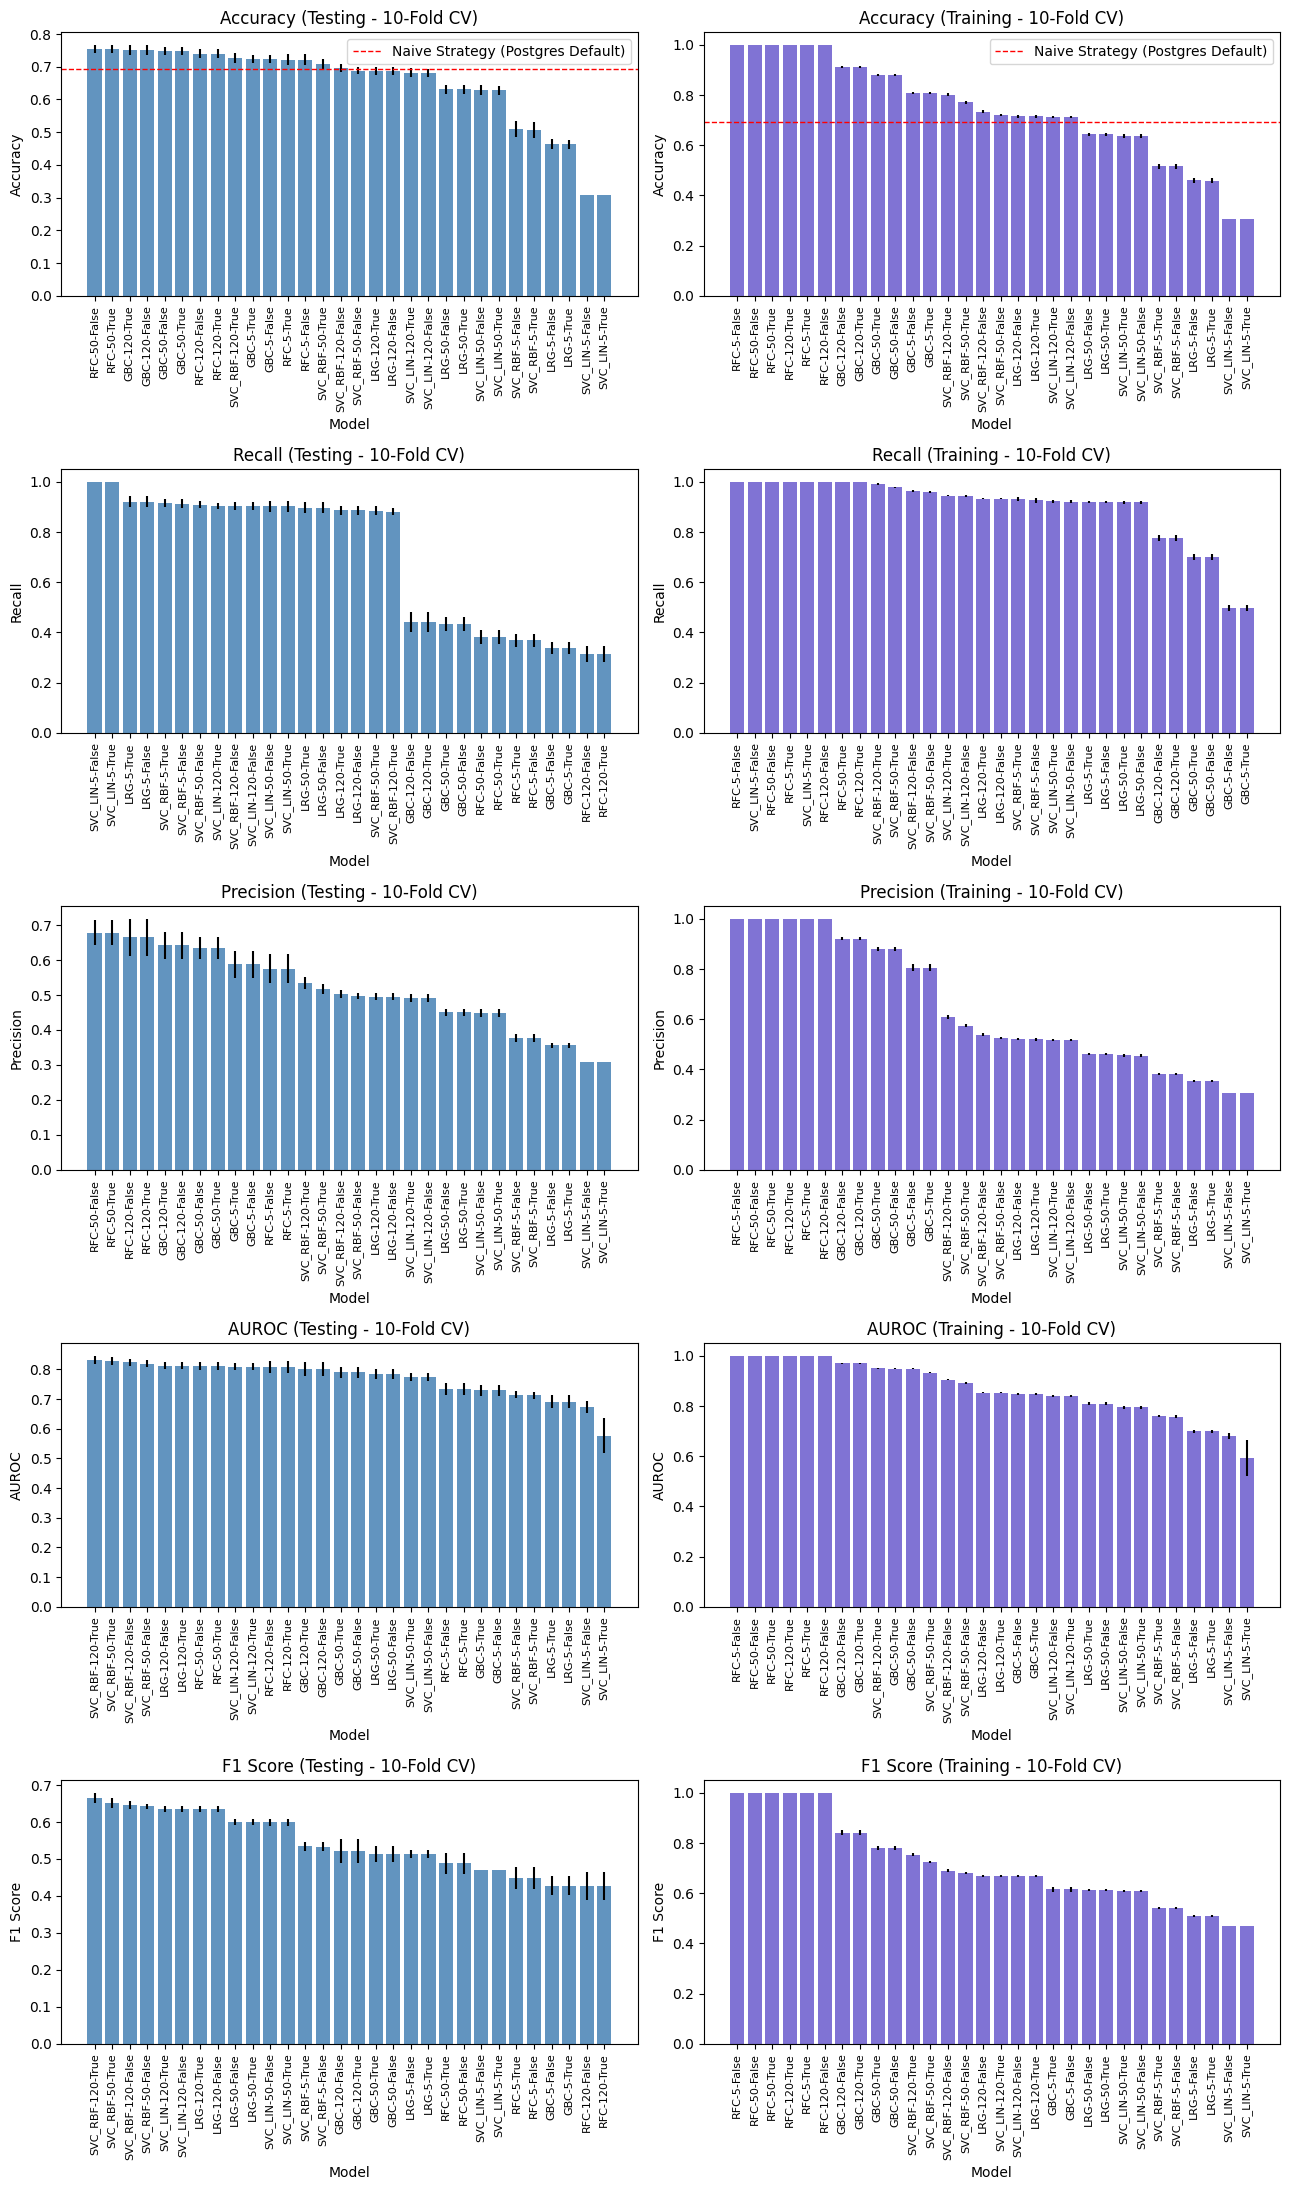

In [30]:

# Define the metrics and their labels
metrics = [
    ('accuracy', 'Accuracy'),
    ('recall', 'Recall'),
    ('precision', 'Precision'),
    ('auroc', 'AUROC'),
    ('f1score', 'F1 Score')
]

# Create subplots: 5 rows × 2 columns (test vs train)
fig, axes = plt.subplots(5, 2, figsize=(13, 22))

# Plotting loop
for row_idx, (metric_key, metric_label) in enumerate(metrics):
    # --- Testing ---
    test_data = model_performances.sort_values(by=f'model_test_{metric_key}_mean', ascending=False)
    axes[row_idx, 0].bar(
        x=test_data['name'],
        height=test_data[f'model_test_{metric_key}_mean'],
        yerr=test_data[f'model_test_{metric_key}_std'],
        color='steelblue',
        alpha=0.85
    )
    axes[row_idx, 0].set_title(f"{metric_label} (Testing - 10-Fold CV)")
    axes[row_idx, 0].set_xlabel('Model')
    axes[row_idx, 0].set_ylabel(metric_label)
    axes[row_idx, 0].tick_params(axis='x', rotation=90, labelsize=8)

    if metric_key == 'accuracy':
        baseline = model_performances.apriori_test_distribution_mean.iloc[0]
        axes[row_idx, 0].axhline(y=baseline, color='red', linestyle='--', linewidth=1)
        axes[row_idx, 0].legend(["Naive Strategy (Postgres Default)"])

    # --- Training ---
    train_data = model_performances.sort_values(by=f'model_train_{metric_key}_mean', ascending=False)
    axes[row_idx, 1].bar(
        x=train_data['name'],
        height=train_data[f'model_train_{metric_key}_mean'],
        yerr=train_data[f'model_train_{metric_key}_std'],
        color='slateblue',
        alpha=0.85
    )
    axes[row_idx, 1].set_title(f"{metric_label} (Training - 10-Fold CV)")
    axes[row_idx, 1].set_xlabel('Model')
    axes[row_idx, 1].set_ylabel(metric_label)
    axes[row_idx, 1].tick_params(axis='x', rotation=90, labelsize=8)

    if metric_key == 'accuracy':
        baseline = model_performances.apriori_train_distribution_mean.iloc[0]
        axes[row_idx, 1].axhline(y=baseline, color='red', linestyle='--', linewidth=1)
        axes[row_idx, 1].legend(["Naive Strategy (Postgres Default)"])

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


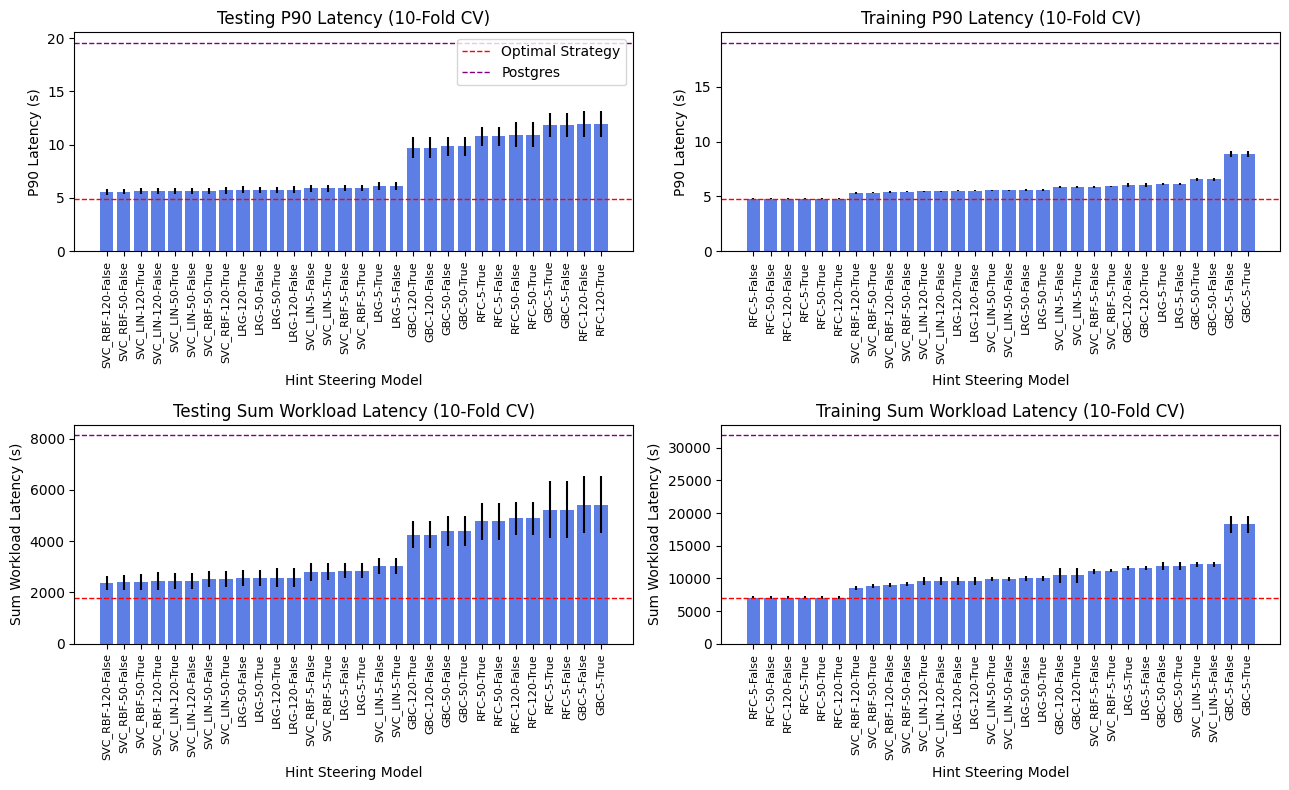

In [31]:
# Define plotting metadata
metrics_info = [
    {
        'row': 0, 'col': 0,
        'title': 'Testing P90 Latency (10-Fold CV)',
        'y_label': 'P90 Latency (s)',
        'mean_col': 'model_test_p90_mean',
        'std_col': 'model_test_p90_std',
        'baseline_apriori': 'test_apriori_p90',
        'baseline_benchmark': 'test_benchmark_p90',
    },
    {
        'row': 1, 'col': 0,
        'title': 'Testing Sum Workload Latency (10-Fold CV)',
        'y_label': 'Sum Workload Latency (s)',
        'mean_col': 'model_test_workload_mean',
        'std_col': 'model_test_workload_std',
        'baseline_apriori': 'test_apriori_workload',
        'baseline_benchmark': 'test_benchmark_workload',
    },
    {
        'row': 0, 'col': 1,
        'title': 'Training P90 Latency (10-Fold CV)',
        'y_label': 'P90 Latency (s)',
        'mean_col': 'model_train_p90_mean',
        'std_col': 'model_train_p90_std',
        'baseline_apriori': 'train_apriori_p90',
        'baseline_benchmark': 'train_benchmark_p90',
    },
    {
        'row': 1, 'col': 1,
        'title': 'Training Sum Workload Latency (10-Fold CV)',
        'y_label': 'Sum Workload Latency (s)',
        'mean_col': 'model_train_workload_mean',
        'std_col': 'model_train_workload_std',
        'baseline_apriori': 'train_apriori_workload',
        'baseline_benchmark': 'train_benchmark_workload',
    }
]

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(13, 8))

# Iterate over each subplot configuration
for config in metrics_info:
    r, c = config['row'], config['col']
    ax = axes[r, c]

    # Sort by metric value
    sorted_data = model_performances.sort_values(by=config['mean_col'])

    # Plot bar with error bars
    ax.bar(
        x=sorted_data['name'],
        height=sorted_data[config['mean_col']],
        yerr=sorted_data[config['std_col']],
        color='royalblue',
        alpha=0.85
    )

    # Format axes
    ax.set_title(config['title'])
    ax.set_xlabel('Hint Steering Model')
    ax.set_ylabel(config['y_label'])
    ax.tick_params(axis='x', labelrotation=90, labelsize=8)

    # Add baseline lines
    apriori_mean = np.mean(np.array(model_performances[config['baseline_apriori']].iloc[0]))
    benchmark_mean = np.mean(np.array(model_performances[config['baseline_benchmark']].iloc[0]))
    ax.axhline(y=apriori_mean, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=benchmark_mean, color='purple', linestyle='--', linewidth=1)

    # Add legend only to the first plot
    if r == 0 and c == 0:
        ax.legend(['Optimal Strategy', 'Postgres'], loc='upper right')
    else:
        ax.legend().remove()

plt.tight_layout()
plt.show()

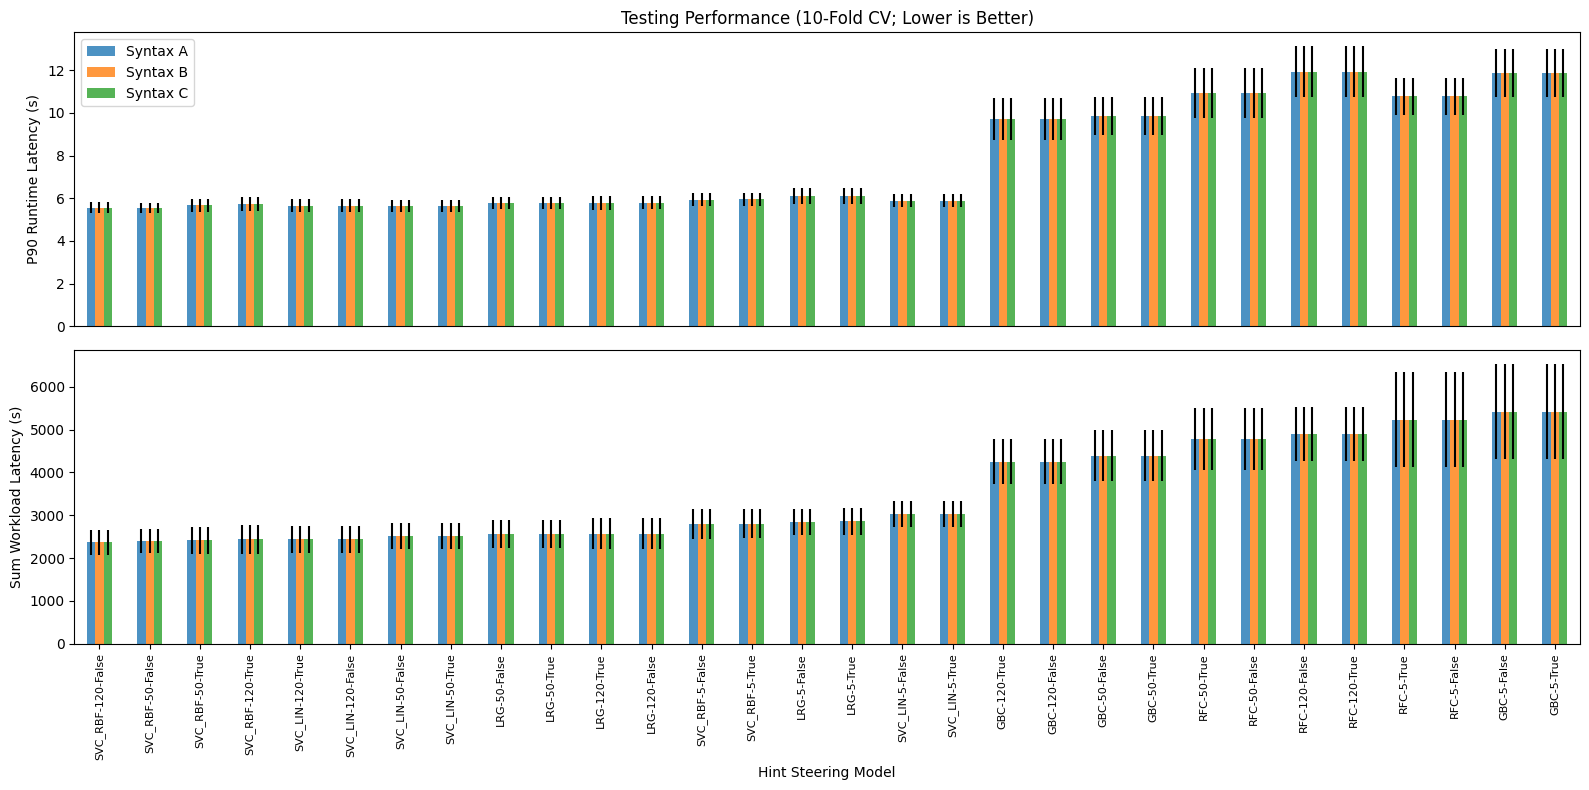

In [32]:
# Prepare bar labels and metric sets
syntax_labels = ["Syntax A", "Syntax B", "Syntax C"]
p90_cols_mean = ['model_test_p90_mean', 'model_spaced_p90_mean', 'model_tabbed_p90_mean']
p90_cols_std = ['model_test_p90_std', 'model_spaced_p90_std', 'model_tabbed_p90_std']

workload_cols_mean = ['model_test_workload_mean', 'model_spaced_workload_mean', 'model_tabbed_workload_mean']
workload_cols_std = ['model_test_workload_std', 'model_spaced_workload_std', 'model_tabbed_workload_std']

# Sort models by base workload latency
sorted_models = model_performances.sort_values(by='model_test_workload_mean')['name']
sorted_index = model_performances.set_index('name').loc[sorted_models]

# Set up plot
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# --- Upper Plot: P90 Latencies ---
sorted_index[p90_cols_mean].plot.bar(
    yerr=sorted_index[p90_cols_std].to_numpy().T,
    ax=axes[0],
    alpha=0.8,
    legend=False
)
axes[0].set_ylabel('P90 Runtime Latency (s)')
axes[0].set_title('Testing Performance (10-Fold CV; Lower is Better)')
axes[0].tick_params(axis='x', bottom=False, labelbottom=False)

# --- Lower Plot: Total Workload Latencies ---
sorted_index[workload_cols_mean].plot.bar(
    yerr=sorted_index[workload_cols_std].to_numpy().T,
    ax=axes[1],
    alpha=0.8
)
axes[1].set_ylabel('Sum Workload Latency (s)')
axes[1].set_xlabel('Hint Steering Model')
axes[1].tick_params(axis='x', labelrotation=90, labelsize=8)

# Add legends
axes[0].legend(syntax_labels)
axes[1].legend().remove()

plt.tight_layout()
plt.show()

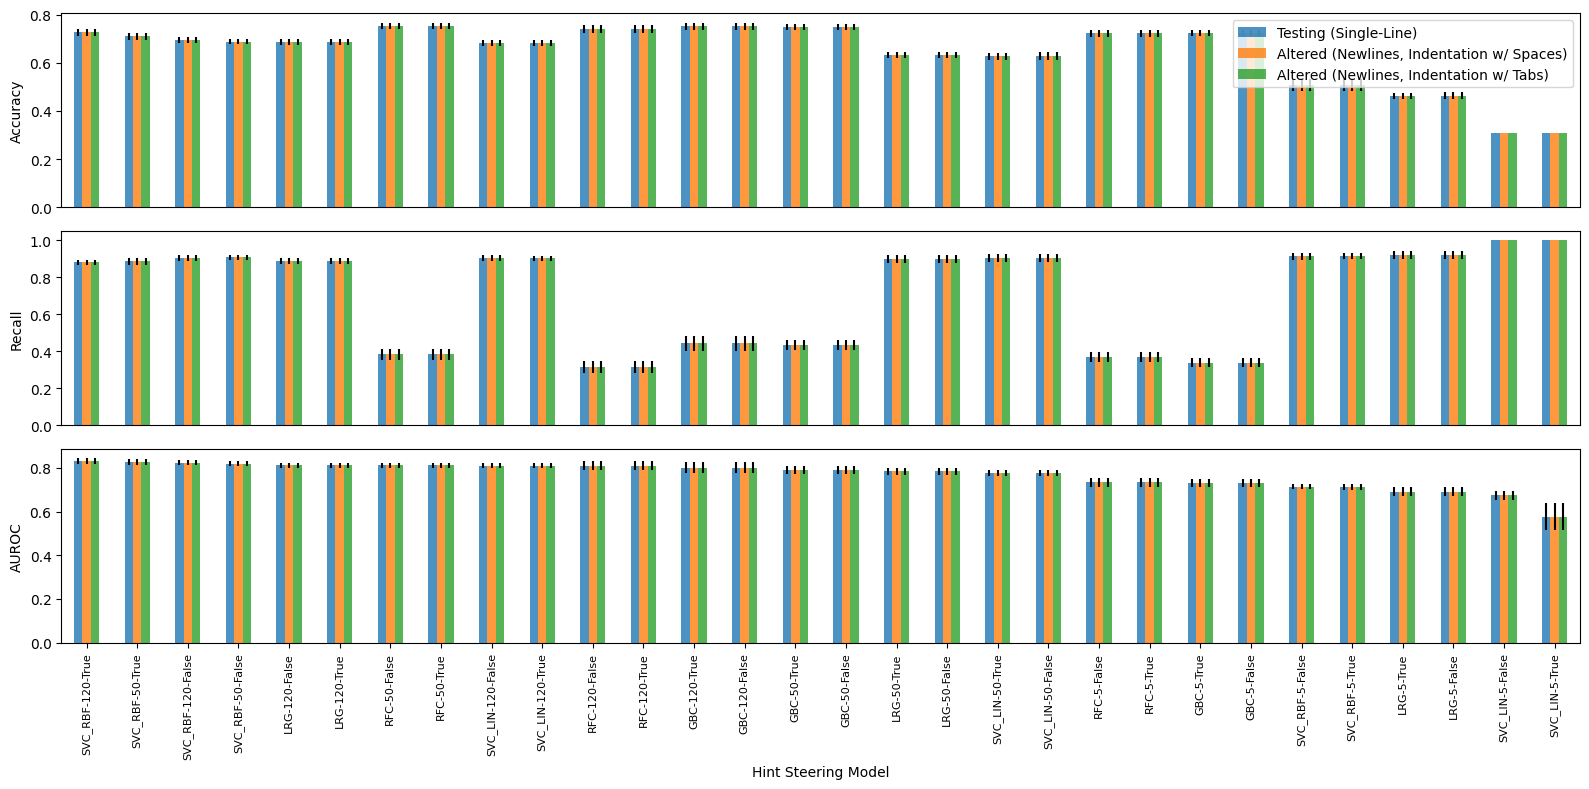

In [33]:
# Define metric groups
metrics = [
    ('accuracy', 'Accuracy'),
    ('recall', 'Recall'),
    ('auroc', 'AUROC')
]

# Syntax label for legend
syntax_styles = [
    "Testing (Single-Line)",
    "Altered (Newlines, Indentation w/ Spaces)",
    "Altered (Newlines, Indentation w/ Tabs)"
]

# Sort models by AUROC for consistent ranking
sorted_models = model_performances.sort_values(by='model_test_auroc_mean', ascending=False)['name']
sorted_df = model_performances.set_index('name').loc[sorted_models]

# Create 3 stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)

# Loop through metrics and plot
for i, (metric_key, metric_label) in enumerate(metrics):
    mean_cols = [
        f'model_test_{metric_key}_mean',
        f'model_spaced_{metric_key}_mean',
        f'model_tabbed_{metric_key}_mean',
    ]
    std_cols = [
        f'model_test_{metric_key}_std',
        f'model_spaced_{metric_key}_std',
        f'model_tabbed_{metric_key}_std',
    ]

    # Plot bars with error bars
    sorted_df[mean_cols].plot.bar(
        yerr=sorted_df[std_cols].to_numpy().T,
        ax=axes[i],
        alpha=0.8,
        legend=False
    )

    axes[i].set_ylabel(metric_label)
    axes[i].set_xlabel('Hint Steering Model')
    axes[i].tick_params(axis='x', labelrotation=90, labelsize=8)

    # Hide x-axis labels for upper plots
    if i < 2:
        axes[i].get_xaxis().set_visible(False)
    else:
        axes[i].set_xlabel('Hint Steering Model')

    # Show legend only once
    if i == 0:
        axes[i].legend(syntax_styles)
    else:
        axes[i].legend().remove()

plt.tight_layout()
plt.show()

### Robustness

In [34]:
best_model = model_performances.loc[[model_performances.model_test_workload_mean.idxmin()]].reset_index(drop=True)
best_model.head()

,name,estimator,scale,model_train_accuracy,model_test_accuracy,model_train_recall,model_test_recall,model_train_precision,model_test_precision,model_train_f1score,...,model_spaced_p90_std,model_spaced_median_std,model_tabbed_accuracy_std,model_tabbed_recall_std,model_tabbed_auroc_std,model_tabbed_precision_std,model_tabbed_f1score_std,model_tabbed_workload_std,model_tabbed_p90_std,model_tabbed_median_std
0,SVC_RBF-120-False,"SVC(class_weight={0: 0.4430238902568817, 1: 2....",False,"[0.7288135593220338, 0.7384437596302003, 0.721...","[0.6907692307692308, 0.7015384615384616, 0.693...","[0.9636135508155583, 0.9661229611041405, 0.963...","[0.93, 0.9, 0.92, 0.885, 0.895, 0.905, 0.89, 0...","[0.5322245322245323, 0.5414908579465542, 0.525...","[0.49865951742627346, 0.5084745762711864, 0.50...","[0.6857142857142857, 0.694006309148265, 0.6802...",...,0.25407,0.078789,0.012766,0.015174,0.012988,0.011668,0.010825,284.905413,0.25407,0.078789


In [35]:
name_parts = best_model['name'][0].split('-')
pcs = int(name_parts[1])
scale = name_parts[2] == 'True'

In [36]:
# Example: suppose best_model['name'][0] == 'SVC_RBF-120-False'
name_parts = best_model['name'][0].split('-')
model_type = name_parts[0]           # e.g., 'SVC_RBF'
pcs = int(name_parts[1])             # e.g., 120
scale = name_parts[2] == 'True'      # e.g., False (as boolean)


  0%|          | 0/650 [00:00<?, ?it/s]

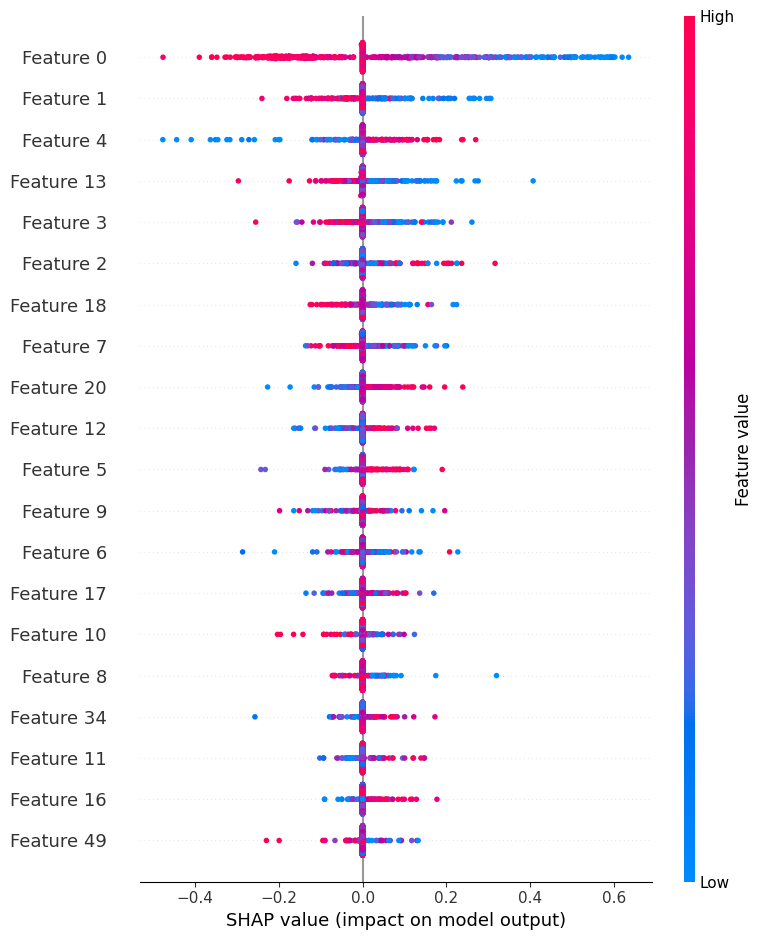

In [37]:
import shap
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Extract model, pca components, and scaling flag
clf = best_model['estimator'][0]
name_parts = best_model['name'][0].split('-')
pcs = int(name_parts[1])
scale = name_parts[2] == 'True'

# 2. Preprocess data as model was trained
if scale:
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
else:
    X_train_scaled = X_train
    X_test_scaled = X_test

pca = PCA(n_components=pcs).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. Select SHAP explainer type
est_name = clf.__class__.__name__.lower()
background = X_train_pca[np.random.choice(X_train_pca.shape[0], 100, replace=False)]

if 'svc' in est_name:
    explainer = shap.KernelExplainer(clf.predict, background)
elif 'randomforest' in est_name or 'xgb' in est_name or 'lgbm' in est_name:
    explainer = shap.TreeExplainer(clf)
elif 'logisticregression' in est_name:
    explainer = shap.LinearExplainer(clf, background)
else:
    explainer = shap.KernelExplainer(clf.predict, background)  # fallback

# 4. Calculate SHAP values and plot
shap_values = explainer.shap_values(X_test_pca, nsamples=100)
shap.summary_plot(shap_values, X_test_pca)
# shap.summary_plot(shap_values, X_test_pca, plot_type='bar')



In [38]:
query_types = {'original', 'spaced', 'tabbed'}
metrics = ['p90', 'sum', 'median']

# Config setup
cfg = {
    'estimator': best_model.loc[0, 'estimator'],
    'pcs': int(best_model.loc[0, 'name'].split('-')[1]),
}
cfg.update({
    qt: {variant: {m: [] for m in metrics} for variant in query_types}
    for qt in query_types
})

# Define helper for extracting input arrays by query type
def get_query_array(qt_name):
    return {
        'original': original_sql,
        'spaced': spaced_sql,
        'tabbed': tabbed_sql
    }[qt_name]

# Start experiments
for qt in query_types:
    print(f"\n[{datetime.now().isoformat()}] Beginning experiments for {qt.capitalize()}")
    base_sql = get_query_array(qt)

    for i, (train_idx, test_idx) in enumerate(StratifiedShuffleSplit(n_splits=k, train_size=p, random_state=RANDOM_SEED).split(original_sql, targets_l)):
        print(f"[{datetime.now().isoformat()}] CV fold {i + 1}")

        # Prepare train/test data
        X_train = pipeline.fit_transform(base_sql[train_idx].numpy())
        y_train = targets_l[train_idx].numpy()

        X_test_dict = {
            'original': pipeline.transform(original_sql[test_idx].numpy()),
            'spaced': pipeline.transform(spaced_sql[test_idx].numpy()),
            'tabbed': pipeline.transform(tabbed_sql[test_idx].numpy())
        }
        y_test = targets_l[test_idx].numpy()

        # Class balancing
        weights = {
            0: (targets_l[train_idx] == 1).sum().item() / (targets_l[train_idx] == 0).sum().item(),
            1: (targets_l[train_idx] == 0).sum().item() / (targets_l[train_idx] == 1).sum().item()
        }

        # Apply class weights if supported
        if hasattr(cfg['estimator'], 'class_weight'):
            cfg['estimator'].class_weight = weights.copy()

        # Train the model
        cfg['estimator'].fit(X_train[:, :cfg['pcs']], y_train)

        # Evaluate each variant
        for variant in query_types:
            X_eval = X_test_dict[variant]
            y_pred = cfg['estimator'].predict(X_eval[:, :cfg['pcs']])
            is_longtail = torch.Tensor(y_pred) > THRESHOLD
            selected_runtimes = hint_l[test_idx].gather(1, torch.where(is_longtail, torch.LongTensor([26]), torch.LongTensor([0])).view(-1, 1))

            p90 = selected_runtimes.quantile(0.90).item()
            total = selected_runtimes.sum().item()
            med = selected_runtimes.median().item()

            # Store into config using calling query type as key
            cfg[qt][variant]['p90'].append(p90)
            cfg[qt][variant]['sum'].append(total)
            cfg[qt][variant]['median'].append(med)



[2025-06-04T11:43:23.901852] Beginning experiments for Spaced
[2025-06-04T11:43:23.904150] CV fold 1
[2025-06-04T11:43:25.229480] CV fold 2
[2025-06-04T11:43:26.505981] CV fold 3
[2025-06-04T11:43:27.742976] CV fold 4
[2025-06-04T11:43:29.008980] CV fold 5
[2025-06-04T11:43:30.223062] CV fold 6
[2025-06-04T11:43:31.463269] CV fold 7
[2025-06-04T11:43:32.607797] CV fold 8
[2025-06-04T11:43:33.824051] CV fold 9
[2025-06-04T11:43:34.973166] CV fold 10

[2025-06-04T11:43:36.142124] Beginning experiments for Tabbed
[2025-06-04T11:43:36.143912] CV fold 1
[2025-06-04T11:43:37.381848] CV fold 2
[2025-06-04T11:43:38.536601] CV fold 3
[2025-06-04T11:43:39.694486] CV fold 4
[2025-06-04T11:43:40.932739] CV fold 5
[2025-06-04T11:43:42.211619] CV fold 6
[2025-06-04T11:43:43.469942] CV fold 7
[2025-06-04T11:43:44.730203] CV fold 8
[2025-06-04T11:43:45.951361] CV fold 9
[2025-06-04T11:43:47.147099] CV fold 10

[2025-06-04T11:43:48.335193] Beginning experiments for Original
[2025-06-04T11:43:48.337314

In [40]:
# Baseline workload values
postgres_workload = np.mean(np.array(best_model.test_benchmark_workload.iloc[0]))
optimal_workload = np.mean(np.array(best_model.test_apriori_workload.iloc[0]))

# For readability
syntax_map = {'original': 'Syntax A', 'spaced': 'Syntax B', 'tabbed': 'Syntax C'}
train_keys = ['original', 'spaced', 'tabbed']
eval_keys = ['original', 'spaced', 'tabbed']

# Iterate and report
for train_key in train_keys:
    print(f"\nTrained on {syntax_map[train_key]}")
    for eval_key in eval_keys:
        syntax_name = syntax_map[eval_key]
        workload_mean = np.mean(cfg[train_key][eval_key]['sum'])

        # Compute deltas
        delta_pg = 1 - (workload_mean / postgres_workload)
        delta_opt = (workload_mean / optimal_workload) - 1

        print(f"[{syntax_name}] Sum workload decrease vs. PostgreSQL: {delta_pg * 100:.2f}%")
        print(f"[{syntax_name}] Sum workload increase vs. Optimal: {delta_opt * 100:.2f}%")



Trained on Syntax A
[Syntax A] Sum workload decrease vs. PostgreSQL: 70.91%
[Syntax A] Sum workload increase vs. Optimal: 33.10%
[Syntax B] Sum workload decrease vs. PostgreSQL: 70.91%
[Syntax B] Sum workload increase vs. Optimal: 33.10%
[Syntax C] Sum workload decrease vs. PostgreSQL: 70.91%
[Syntax C] Sum workload increase vs. Optimal: 33.10%

Trained on Syntax B
[Syntax A] Sum workload decrease vs. PostgreSQL: 70.91%
[Syntax A] Sum workload increase vs. Optimal: 33.10%
[Syntax B] Sum workload decrease vs. PostgreSQL: 70.91%
[Syntax B] Sum workload increase vs. Optimal: 33.10%
[Syntax C] Sum workload decrease vs. PostgreSQL: 70.91%
[Syntax C] Sum workload increase vs. Optimal: 33.10%

Trained on Syntax C
[Syntax A] Sum workload decrease vs. PostgreSQL: 70.91%
[Syntax A] Sum workload increase vs. Optimal: 33.10%
[Syntax B] Sum workload decrease vs. PostgreSQL: 70.91%
[Syntax B] Sum workload increase vs. Optimal: 33.10%
[Syntax C] Sum workload decrease vs. PostgreSQL: 70.91%
[Syntax C

### Figures

#### Performance

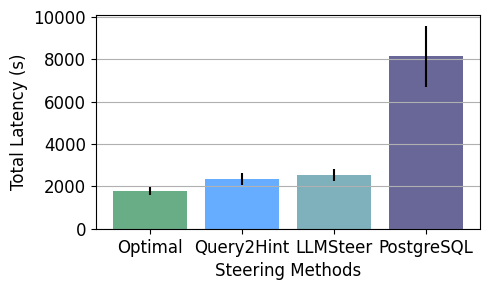

In [42]:
# performance
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Optimal',
    height=np.array(best_model.test_apriori_workload.iloc[0]).mean(),
    yerr=np.array(best_model.test_apriori_workload.iloc[0]).std(),
    alpha=0.6,
    color="#057736",
)
axs.bar(
    x='Query2Hint',
    height=best_model.model_test_workload_mean,
    yerr=best_model.model_test_workload_std,
    alpha=0.6,
    color="#0077ff",
)

axs.bar(
    x='LLMSteer',
    height=2547.7,
    yerr=best_model.model_test_workload_std,
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='PostgreSQL',
    height=np.array(best_model.test_benchmark_workload.iloc[0]).mean(),
    yerr=np.array(best_model.test_benchmark_workload.iloc[0]).std(),
    alpha=0.6,
    color="#060053",
)


axs.grid(axis='y')
axs.set_ylabel('Total Latency (s)', fontdict={'size': '12'})
axs.set_xlabel('Steering Methods', fontdict={'size': '12'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '12'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '12'})


plt.tight_layout()
plt.savefig('./ouputs/alternative_hint/figures/sum.pdf', format='pdf', dpi='figure', bbox_inches='tight')

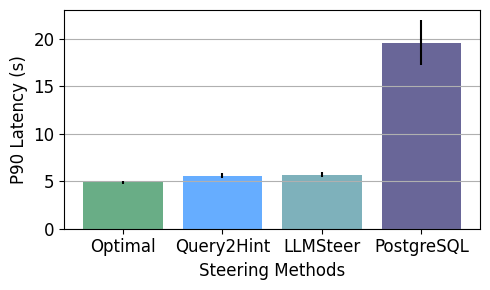

In [43]:
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Optimal',
    height=np.array(best_model.test_apriori_p90.iloc[0]).mean(),
    yerr=np.array(best_model.test_apriori_p90.iloc[0]).std(),
    alpha=0.6,
    color="#057736",
)
axs.bar(
    x='Query2Hint',
    height=best_model.model_test_p90_mean,
    yerr=best_model.model_test_p90_std,
    alpha=0.6,
    color="#0077ff",
)

axs.bar(
    x='LLMSteer',
    height=5.7,
    yerr=best_model.model_test_p90_std,
    alpha=0.6,
    color='#287D8EFF',
)

axs.bar(
    x='PostgreSQL',
    height=np.array(best_model.test_benchmark_p90.iloc[0]).mean(),
    yerr=np.array(best_model.test_benchmark_p90.iloc[0]).std(),
    alpha=0.6,
    color="#060053",
)

axs.grid(axis='y')
axs.set_ylabel('P90 Latency (s)', fontdict={'size': '12'})
axs.set_xlabel('Steering Methods', fontdict={'size': '12'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '12'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '12'})

plt.tight_layout()
plt.savefig('./ouputs/alternative_hint/figures/p90.pdf', format='pdf', dpi='figure', bbox_inches='tight')

In [44]:
height=best_model.model_test_p90_mean

#### Robustness

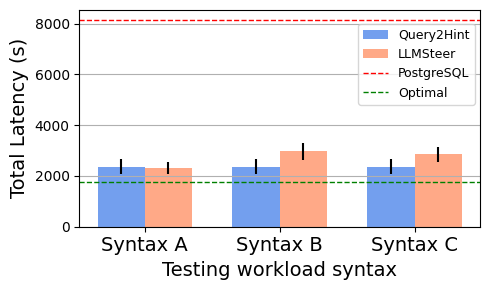

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
fig, axs = plt.subplots(figsize=(5, 3))
x = np.arange(3)  # [0, 1, 2]
bar_width = 0.35
labels = ['Syntax A', 'Syntax B', 'Syntax C']

# Query2Hint values from cfg
q2hint_means = [
    np.array(cfg['original']['original']['sum']).mean(),
    np.array(cfg['original']['spaced']['sum']).mean(),
    np.array(cfg['original']['tabbed']['sum']).mean()
]
q2hint_stds = [
    np.array(cfg['original']['original']['sum']).std(),
    np.array(cfg['original']['spaced']['sum']).std(),
    np.array(cfg['original']['tabbed']['sum']).std()
]

# LLMSTEER means from % reduction on PostgreSQL mean
pgsql_mean = np.array(best_model.test_benchmark_workload.iloc[0]).mean()
llmsteer_means = [
    pgsql_mean * (1 - 0.7151),
    pgsql_mean * (1 - 0.6351),
    pgsql_mean * (1 - 0.6494)
]

# LLMSTEER stds (real values from best_model)
llmsteer_stds = [245.51,322.31,308.49
]

# Bar plot
Q2hint=axs.bar(x - bar_width/2, q2hint_means, width=bar_width, yerr=q2hint_stds, label='Query2Hint', color='#6495ED', alpha=0.9)
LLmsteer=axs.bar(x + bar_width/2, llmsteer_means, width=bar_width, yerr=llmsteer_stds, label='LLMSTEER', color='#FFA07A', alpha=0.9)

# Reference lines
line_pgsql = axs.axhline(y=pgsql_mean, color='red', ls='--', lw=1)
line_optimal = axs.axhline(y=np.array(best_model.test_apriori_workload.iloc[0]).mean(), color='green', ls='--', lw=1)
# line_q2hint_line = axs.axhline(y=np.array(best_model.model_test_workload_mean.iloc[0]).mean(), color='#154360', ls='--', lw=1)

# Formatting
axs.set_xticks(x)
axs.set_xticklabels(labels, fontsize=14)
axs.set_ylabel('Total Latency (s)', fontsize=14)
axs.set_xlabel('Testing workload syntax', fontsize=14)
axs.grid(axis='y')

# Legends
axs.legend(
    [Q2hint, LLmsteer, line_pgsql, line_optimal],
    ['Query2Hint', 'LLMSteer', 'PostgreSQL', 'Optimal'],
    loc='center left',
    bbox_to_anchor=(0.68, 0.75),
    fontsize=9,
    frameon=True
)


plt.tight_layout()
plt.show()


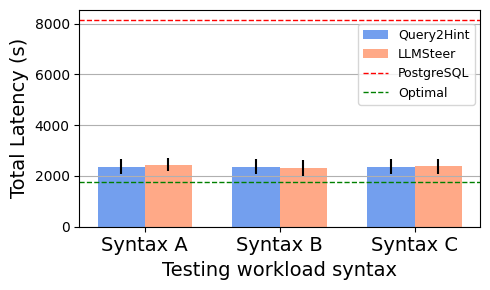

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
fig, axs = plt.subplots(figsize=(5, 3))
x = np.arange(3)  # [0, 1, 2]
bar_width = 0.35
labels = ['Syntax A', 'Syntax B', 'Syntax C']

# Query2Hint values from cfg
q2hint_means = [
    np.array(cfg['spaced']['original']['sum']).mean(),
    np.array(cfg['spaced']['spaced']['sum']).mean(),
    np.array(cfg['spaced']['tabbed']['sum']).mean()
]
q2hint_stds = [
    np.array(cfg['spaced']['original']['sum']).std(),
    np.array(cfg['spaced']['spaced']['sum']).std(),
    np.array(cfg['spaced']['tabbed']['sum']).std()
]

# LLMSTEER means from % reduction on PostgreSQL mean
pgsql_mean = np.array(best_model.test_benchmark_workload.iloc[0]).mean()
llmsteer_means = [
    pgsql_mean * (1 - 0.6990),
    pgsql_mean * (1 - 0.7144),
    pgsql_mean * (1 - 0.7074)
]

# LLMSTEER stds (real values from best_model)
llmsteer_stds = [245.51,322.31,308.49
]

# Bar plot
Q2hint=axs.bar(x - bar_width/2, q2hint_means, width=bar_width, yerr=q2hint_stds, label='Query2Hint', color='#6495ED', alpha=0.9)
LLmsteer=axs.bar(x + bar_width/2, llmsteer_means, width=bar_width, yerr=llmsteer_stds, label='LLMSTEER', color='#FFA07A', alpha=0.9)

# Reference lines
line_pgsql = axs.axhline(y=pgsql_mean, color='red', ls='--', lw=1)
line_optimal = axs.axhline(y=np.array(best_model.test_apriori_workload.iloc[0]).mean(), color='green', ls='--', lw=1)
# line_q2hint_line = axs.axhline(y=np.array(best_model.model_test_workload_mean.iloc[0]).mean(), color='#154360', ls='--', lw=1)

# Formatting
axs.set_xticks(x)
axs.set_xticklabels(labels, fontsize=14)
axs.set_ylabel('Total Latency (s)', fontsize=14)
axs.set_xlabel('Testing workload syntax', fontsize=14)
axs.grid(axis='y')

# Legends
axs.legend(
    [Q2hint, LLmsteer, line_pgsql, line_optimal],
    ['Query2Hint', 'LLMSteer', 'PostgreSQL', 'Optimal'],
    loc='center left',
    bbox_to_anchor=(0.68, 0.75),
    fontsize=9,
    frameon=True
)


plt.tight_layout()
plt.show()


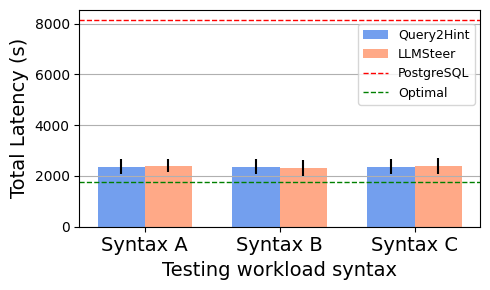

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
fig, axs = plt.subplots(figsize=(5, 3))
x = np.arange(3)  # [0, 1, 2]
bar_width = 0.35
labels = ['Syntax A', 'Syntax B', 'Syntax C']

# Query2Hint values from cfg
q2hint_means = [
    np.array(cfg['tabbed']['original']['sum']).mean(),
    np.array(cfg['tabbed']['spaced']['sum']).mean(),
    np.array(cfg['tabbed']['tabbed']['sum']).mean()
]
q2hint_stds = [
    np.array(cfg['tabbed']['original']['sum']).std(),
    np.array(cfg['tabbed']['spaced']['sum']).std(),
    np.array(cfg['tabbed']['tabbed']['sum']).std()
]

# LLMSTEER means from % reduction on PostgreSQL mean
pgsql_mean = np.array(best_model.test_benchmark_workload.iloc[0]).mean()
llmsteer_means = [
    pgsql_mean * (1 - 0.7036),
    pgsql_mean * (1 - 0.7147),
    pgsql_mean * (1 - 0.7052)
]

# LLMSTEER stds (real values from best_model)
llmsteer_stds = [245.51,322.31,308.49
]

# Bar plot
Q2hint=axs.bar(x - bar_width/2, q2hint_means, width=bar_width, yerr=q2hint_stds, label='Query2Hint', color='#6495ED', alpha=0.9)
LLmsteer=axs.bar(x + bar_width/2, llmsteer_means, width=bar_width, yerr=llmsteer_stds, label='LLMSTEER', color='#FFA07A', alpha=0.9)

# Reference lines
line_pgsql = axs.axhline(y=pgsql_mean, color='red', ls='--', lw=1)
line_optimal = axs.axhline(y=np.array(best_model.test_apriori_workload.iloc[0]).mean(), color='green', ls='--', lw=1)
# line_q2hint_line = axs.axhline(y=np.array(best_model.model_test_workload_mean.iloc[0]).mean(), color='#154360', ls='--', lw=1)

# Formatting
axs.set_xticks(x)
axs.set_xticklabels(labels, fontsize=14)
axs.set_ylabel('Total Latency (s)', fontsize=14)
axs.set_xlabel('Testing workload syntax', fontsize=14)
axs.grid(axis='y')

# Legends
axs.legend(
    [Q2hint, LLmsteer, line_pgsql, line_optimal],
    ['Query2Hint', 'LLMSteer', 'PostgreSQL', 'Optimal'],
    loc='center left',
    bbox_to_anchor=(0.68, 0.75),
    fontsize=9,
    frameon=True
)


plt.tight_layout()
plt.show()


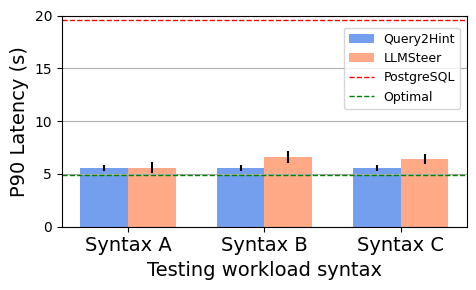

In [48]:
# Syntax A Training
import numpy as np
import matplotlib.pyplot as plt

# Setup
fig, axs = plt.subplots(figsize=(5, 3))
x = np.arange(3)  # [0, 1, 2]
bar_width = 0.35
labels = ['Syntax A', 'Syntax B', 'Syntax C']

# Query2Hint values from cfg
q2hint_means = [
    np.array(cfg['original']['original']['p90']).mean(),
    np.array(cfg['original']['spaced']['p90']).mean(),
    np.array(cfg['original']['tabbed']['p90']).mean()
]
q2hint_stds = [
    np.array(cfg['original']['original']['p90']).std(),
    np.array(cfg['original']['spaced']['p90']).std(),
    np.array(cfg['original']['tabbed']['p90']).std()
]

# LLMSTEER means from % reduction on PostgreSQL mean
pgsql_mean = np.array(best_model.test_benchmark_p90.iloc[0]).mean()
llmsteer_means = [5.6, 6.6, 6.4]

# LLMSTEER stds (real values from best_model)
llmsteer_stds = [0.5, 0.6, 0.5]
# Bar plot
Q2hint=axs.bar(x - bar_width/2, q2hint_means, width=bar_width, yerr=q2hint_stds, label='Query2Hint', color='#6495ED', alpha=0.9)
LLmsteer=axs.bar(x + bar_width/2, llmsteer_means, width=bar_width, yerr=llmsteer_stds, label='LLMSTEER', color='#FFA07A', alpha=0.9)

# Reference lines
line_pgsql = axs.axhline(y=pgsql_mean, color='red', ls='--', lw=1)
line_optimal = axs.axhline(y=np.array(best_model.test_apriori_p90.iloc[0]).mean(), color='green', ls='--', lw=1)
# line_q2hint_line = axs.axhline(y=np.array(best_model.model_test_workload_mean.iloc[0]).mean(), color='#154360', ls='--', lw=1)

# Formatting
axs.set_xticks(x)
axs.set_xticklabels(labels, fontsize=14)
axs.set_ylabel('P90 Latency (s)', fontsize=14)
axs.set_xlabel('Testing workload syntax', fontsize=14)
axs.set_ylim(0, 20)
axs.grid(axis='y')

# Legends
axs.legend(
    [Q2hint, LLmsteer, line_pgsql, line_optimal],
    ['Query2Hint', 'LLMSteer', 'PostgreSQL', 'Optimal'],
    loc='center left',
    bbox_to_anchor=(0.68, 0.75),
    fontsize=9,
    frameon=True
)


plt.tight_layout()
plt.show()


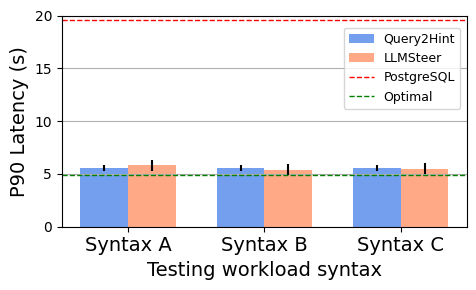

In [49]:
# Syntax B Training
import numpy as np
import matplotlib.pyplot as plt

# Setup
fig, axs = plt.subplots(figsize=(5, 3))
x = np.arange(3)  # [0, 1, 2]
bar_width = 0.35
labels = ['Syntax A', 'Syntax B', 'Syntax C']

# Query2Hint values from cfg
q2hint_means = [
    np.array(cfg['spaced']['original']['p90']).mean(),
    np.array(cfg['spaced']['spaced']['p90']).mean(),
    np.array(cfg['spaced']['tabbed']['p90']).mean()
]
q2hint_stds = [
    np.array(cfg['spaced']['original']['p90']).std(),
    np.array(cfg['spaced']['spaced']['p90']).std(),
    np.array(cfg['spaced']['tabbed']['p90']).std()
]

# LLMSTEER means from % reduction on PostgreSQL mean
pgsql_mean = np.array(best_model.test_benchmark_p90.iloc[0]).mean()
llmsteer_means = [5.8, 5.4, 5.5]

# LLMSTEER stds (real values from best_model)
llmsteer_stds = [0.5, 0.5, 0.5]
# Bar plot
Q2hint=axs.bar(x - bar_width/2, q2hint_means, width=bar_width, yerr=q2hint_stds, label='Query2Hint', color='#6495ED', alpha=0.9)
LLmsteer=axs.bar(x + bar_width/2, llmsteer_means, width=bar_width, yerr=llmsteer_stds, label='LLMSTEER', color='#FFA07A', alpha=0.9)

# Reference lines
line_pgsql = axs.axhline(y=pgsql_mean, color='red', ls='--', lw=1)
line_optimal = axs.axhline(y=np.array(best_model.test_apriori_p90.iloc[0]).mean(), color='green', ls='--', lw=1)
# line_q2hint_line = axs.axhline(y=np.array(best_model.model_test_workload_mean.iloc[0]).mean(), color='#154360', ls='--', lw=1)

# Formatting
axs.set_xticks(x)
axs.set_xticklabels(labels, fontsize=14)
axs.set_ylabel('P90 Latency (s)', fontsize=14)
axs.set_xlabel('Testing workload syntax', fontsize=14)
axs.set_ylim(0, 20)
axs.grid(axis='y')

# Legends
axs.legend(
    [Q2hint, LLmsteer, line_pgsql, line_optimal],
    ['Query2Hint', 'LLMSteer', 'PostgreSQL', 'Optimal'],
    loc='center left',
    bbox_to_anchor=(0.68, 0.75),
    fontsize=9,
    frameon=True
)


plt.tight_layout()
plt.show()


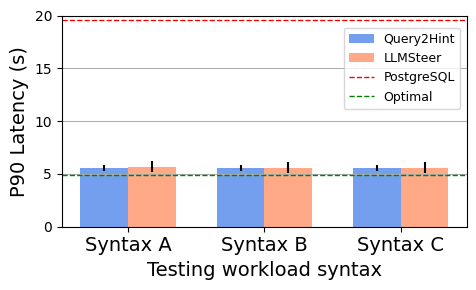

In [50]:
# Syntax B Training
import numpy as np
import matplotlib.pyplot as plt

# Setup
fig, axs = plt.subplots(figsize=(5, 3))
x = np.arange(3)  # [0, 1, 2]
bar_width = 0.35
labels = ['Syntax A', 'Syntax B', 'Syntax C']

# Query2Hint values from cfg
q2hint_means = [
    np.array(cfg['tabbed']['original']['p90']).mean(),
    np.array(cfg['tabbed']['spaced']['p90']).mean(),
    np.array(cfg['tabbed']['tabbed']['p90']).mean()
]
q2hint_stds = [
    np.array(cfg['tabbed']['original']['p90']).std(),
    np.array(cfg['tabbed']['spaced']['p90']).std(),
    np.array(cfg['tabbed']['tabbed']['p90']).std()
]

# LLMSTEER means from % reduction on PostgreSQL mean
pgsql_mean = np.array(best_model.test_benchmark_p90.iloc[0]).mean()
llmsteer_means = [5.7, 5.6, 5.6]

# LLMSTEER stds (real values from best_model)
llmsteer_stds = [0.5, 0.5, 0.5]
# Bar plot
Q2hint=axs.bar(x - bar_width/2, q2hint_means, width=bar_width, yerr=q2hint_stds, label='Query2Hint', color='#6495ED', alpha=0.9)
LLmsteer=axs.bar(x + bar_width/2, llmsteer_means, width=bar_width, yerr=llmsteer_stds, label='LLMSTEER', color='#FFA07A', alpha=0.9)

# Reference lines
line_pgsql = axs.axhline(y=pgsql_mean, color='red', ls='--', lw=1)
line_optimal = axs.axhline(y=np.array(best_model.test_apriori_p90.iloc[0]).mean(), color='green', ls='--', lw=1)
# line_q2hint_line = axs.axhline(y=np.array(best_model.model_test_workload_mean.iloc[0]).mean(), color='#154360', ls='--', lw=1)

# Formatting
axs.set_xticks(x)
axs.set_xticklabels(labels, fontsize=14)
axs.set_ylabel('P90 Latency (s)', fontsize=14)
axs.set_xlabel('Testing workload syntax', fontsize=14)
axs.set_ylim(0, 20)
axs.grid(axis='y')

# Legends
axs.legend(
    [Q2hint, LLmsteer, line_pgsql, line_optimal],
    ['Query2Hint', 'LLMSteer', 'PostgreSQL', 'Optimal'],
    loc='center left',
    bbox_to_anchor=(0.68, 0.75),
    fontsize=9,
    frameon=True
)


plt.tight_layout()
plt.show()
